# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# df.drop('in_btc', axis=1, inplace=True)
# df.drop('out_btc', axis=1, inplace=True)
# df.drop('total_btc', axis=1, inplace=True)
# df.drop('mean_in_btc', axis=1, inplace=True)
# df.drop('mean_out_btc', axis=1, inplace=True)


df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [7]:
del df #free memory
gc.collect()

44

# Split

In [8]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [9]:
pd.value_counts(original_ytrain)

0    24198425
1          82
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

In [11]:
del scaled_df #free memory
gc.collect()

55

# Get Training Sample

In [12]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Get Test Sample

In [13]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Oversample Training Data

In [14]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

# Evaluation Metrics

In [15]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

# Save Model

In [16]:
model_path = './Models/IForest/'

def save_model(model, path):
    pickle.dump(model, open(path, 'wb'))

# Fit Model

In [17]:
from pyod.models.iforest import IForest

iterations = 20
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
oversampling_fraction = 0.057
outliers_fraction = oversampling_fraction

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))

def fit_model(X_train):
    clf = IForest(n_estimators=40, contamination=outliers_fraction, random_state=random_state, n_jobs=-1)
    clf.fit(X_train)
    return clf

Training Parameters:

Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.057
Outliers Fraction: 0.057


# Iterative Modeling

In [18]:
training_evaluations = {}
test_evaluations = {}
model = {}


for i in range(0, iterations):
    sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
    print("Iteration "+ str(i+1) + " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(X_train)
    end = time.time()
    save_model(clf, model_path+'i='+str(i+1)+'.h5')
    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    training_time = round(end - start, 4)
    model[i+1] = clf
    training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)
    
#     print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    y_test_pred = clf.predict(original_Xtest)
    y_test_scores = clf.decision_function(original_Xtest)
    test_end = time.time()
    testing_time = round(test_end - test_start, 4)
    test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

    print("Iteration: (" + str((i+1)) + "/" + str(iterations) + ")    Training Time: "+str(training_time)+" seconds     Testing Time: "+ str(testing_time)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration: (1/20)    Training Time: 93.6913 seconds     Testing Time: 211.0259 seconds
Iteration 2 in progress...
Iteration: (2/20)    Training Time: 72.668 seconds     Testing Time: 201.7576 seconds
Iteration 3 in progress...
Iteration: (3/20)    Training Time: 72.3175 seconds     Testing Time: 208.0658 seconds
Iteration 4 in progress...
Iteration: (4/20)    Training Time: 72.8744 seconds     Testing Time: 198.8027 seconds
Iteration 5 in progress...
Iteration: (5/20)    Training Time: 72.6013 seconds     Testing Time: 221.3265 seconds
Iteration 6 in progress...
Iteration: (6/20)    Training Time: 93.6141 seconds     Testing Time: 254.02 seconds
Iteration 7 in progress...
Iteration: (7/20)    Training Time: 93.7485 seconds     Testing Time: 255.7002 seconds
Iteration 8 in progress...
Iteration: (8/20)    Training Time: 93.4799 seconds     Testing Time: 261.235 seconds
Iteration 9 in progress...
Iteration: (9/20)    Training Time: 93.7041 seconds     Testing T

# Tabular Evaluation

In [19]:
training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(training_evaluations.keys()):
    training_eval_df = training_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : training_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : training_evaluations[it]['macro_precision'],
                             'Macro-Recall' : training_evaluations[it]['macro_recall'],
                             'Macro-F1' : training_evaluations[it]['macro_f1'],
                             'Macro-ROC' : training_evaluations[it]['macro_roc'],
                             'Precision' : training_evaluations[it]['precision'],
                             'Recall' : training_evaluations[it]['recall'],
                             'F1' : training_evaluations[it]['f1'],
                             'ROC' : training_evaluations[it]['roc'],
                             'Time' : training_evaluations[it]['time']                                              
                            }, ignore_index=True)
    
for it in list(test_evaluations.keys()):
    test_eval_df = test_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : test_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : test_evaluations[it]['macro_precision'],
                             'Macro-Recall' : test_evaluations[it]['macro_recall'],
                             'Macro-F1' : test_evaluations[it]['macro_f1'],
                             'Macro-ROC' : test_evaluations[it]['macro_roc'],
                             'Precision' : test_evaluations[it]['precision'],
                             'Recall' : test_evaluations[it]['recall'],
                             'F1' : test_evaluations[it]['f1'],
                             'ROC' : test_evaluations[it]['roc'],
                             'Time' : test_evaluations[it]['time']                                              
                            }, ignore_index=True)

In [20]:
training_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
15,16,0.944288,0.733215,0.727564,0.733215,0.730347,0.877941,0.483863,0.496625,0.490161,0.877941,93.2479
3,4,0.942917,0.733721,0.721837,0.733721,0.727591,0.880167,0.472310,0.499235,0.485400,0.880167,72.8744
13,14,0.942915,0.733703,0.721827,0.733703,0.727577,0.873728,0.472292,0.499199,0.485373,0.873728,93.8357
18,19,0.942477,0.731424,0.719772,0.731424,0.725416,0.877053,0.468431,0.494856,0.481281,0.877053,92.8283
0,1,0.942361,0.730980,0.719247,0.730980,0.724928,0.869639,0.467428,0.494044,0.480368,0.869639,93.6913
4,5,0.942357,0.730625,0.719188,0.730625,0.724730,0.869266,0.467350,0.493297,0.479973,0.869266,72.6013
9,10,0.941957,0.729012,0.717370,0.729012,0.723007,0.874808,0.463887,0.490325,0.476740,0.874808,96.4204
14,15,0.941899,0.728732,0.717102,0.728732,0.722733,0.874072,0.463380,0.489796,0.476222,0.874072,93.9140
6,7,0.941670,0.727586,0.716033,0.727586,0.721626,0.864868,0.461366,0.487621,0.474130,0.864868,93.7485
5,6,0.941509,0.726762,0.715279,0.726762,0.720839,0.875373,0.459948,0.486055,0.472641,0.875373,93.6141


In [21]:
training_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
3,4,0.942917,0.733721,0.721837,0.733721,0.727591,0.880167,0.472310,0.499235,0.485400,0.880167,72.8744
15,16,0.944288,0.733215,0.727564,0.733215,0.730347,0.877941,0.483863,0.496625,0.490161,0.877941,93.2479
18,19,0.942477,0.731424,0.719772,0.731424,0.725416,0.877053,0.468431,0.494856,0.481281,0.877053,92.8283
5,6,0.941509,0.726762,0.715279,0.726762,0.720839,0.875373,0.459948,0.486055,0.472641,0.875373,93.6141
16,17,0.941373,0.726154,0.714654,0.726154,0.720221,0.874820,0.458764,0.484916,0.471478,0.874820,93.1396
9,10,0.941957,0.729012,0.717370,0.729012,0.723007,0.874808,0.463887,0.490325,0.476740,0.874808,96.4204
14,15,0.941899,0.728732,0.717102,0.728732,0.722733,0.874072,0.463380,0.489796,0.476222,0.874072,93.9140
11,12,0.941231,0.725456,0.713992,0.725456,0.719542,0.874049,0.457515,0.483597,0.470195,0.874049,93.3739
13,14,0.942915,0.733703,0.721827,0.733703,0.727577,0.873728,0.472292,0.499199,0.485373,0.873728,93.8357
17,18,0.940241,0.720592,0.709387,0.720592,0.714812,0.872835,0.448832,0.474389,0.461257,0.872835,94.9744


In [23]:
test_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
15,16,0.969937,0.792662,0.500043,0.792662,0.492457,0.905661,0.000088,0.615385,0.000176,0.905661,253.7361
3,4,0.968476,0.772701,0.500038,0.772701,0.492071,0.906247,0.000079,0.576923,0.000157,0.906247,198.8027
13,14,0.968226,0.791806,0.500041,0.791806,0.492012,0.914880,0.000083,0.615385,0.000166,0.914880,256.5248
18,19,0.968024,0.791705,0.500040,0.791705,0.491959,0.907029,0.000083,0.615385,0.000165,0.907029,253.1945
0,1,0.968016,0.772470,0.500038,0.772470,0.491952,0.912436,0.000077,0.576923,0.000155,0.912436,211.0259
4,5,0.967912,0.791649,0.500040,0.791649,0.491930,0.904008,0.000082,0.615385,0.000165,0.904008,221.3265
9,10,0.967791,0.791589,0.500040,0.791589,0.491898,0.911635,0.000082,0.615385,0.000164,0.911635,257.2346
6,7,0.967748,0.791567,0.500040,0.791567,0.491887,0.915841,0.000082,0.615385,0.000164,0.915841,255.7002
10,11,0.967697,0.791542,0.500040,0.791542,0.491874,0.905725,0.000082,0.615385,0.000164,0.905725,250.2062
1,2,0.967673,0.753068,0.500035,0.753068,0.491857,0.913306,0.000072,0.538462,0.000143,0.913306,201.7576


In [22]:
test_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
6,7,0.967748,0.791567,0.500040,0.791567,0.491887,0.915841,0.000082,0.615385,0.000164,0.915841,255.7002
13,14,0.968226,0.791806,0.500041,0.791806,0.492012,0.914880,0.000083,0.615385,0.000166,0.914880,256.5248
17,18,0.966661,0.752562,0.500034,0.752562,0.491593,0.913511,0.000069,0.538462,0.000139,0.913511,256.8337
1,2,0.967673,0.753068,0.500035,0.753068,0.491857,0.913306,0.000072,0.538462,0.000143,0.913306,201.7576
0,1,0.968016,0.772470,0.500038,0.772470,0.491952,0.912436,0.000077,0.576923,0.000155,0.912436,211.0259
9,10,0.967791,0.791589,0.500040,0.791589,0.491898,0.911635,0.000082,0.615385,0.000164,0.911635,257.2346
8,9,0.966720,0.752592,0.500034,0.752592,0.491609,0.911368,0.000069,0.538462,0.000139,0.911368,255.3841
14,15,0.967632,0.791509,0.500040,0.791509,0.491856,0.910965,0.000082,0.615385,0.000163,0.910965,252.4534
11,12,0.967365,0.791376,0.500040,0.791376,0.491787,0.907348,0.000081,0.615385,0.000162,0.907348,256.3384
5,6,0.967486,0.752975,0.500035,0.752975,0.491808,0.907191,0.000071,0.538462,0.000142,0.907191,254.0200


# Visualization

### Metrics

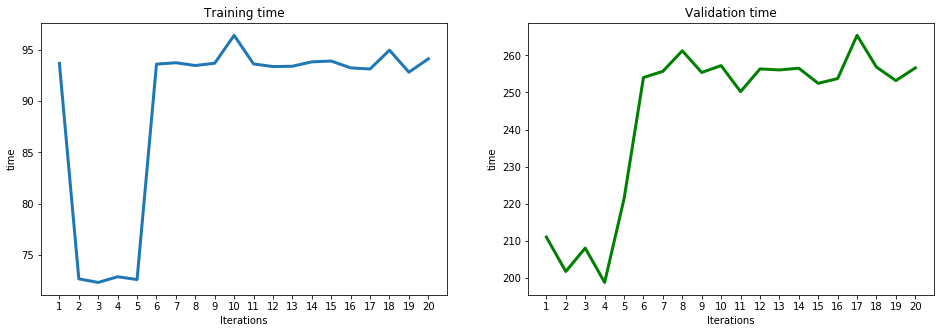

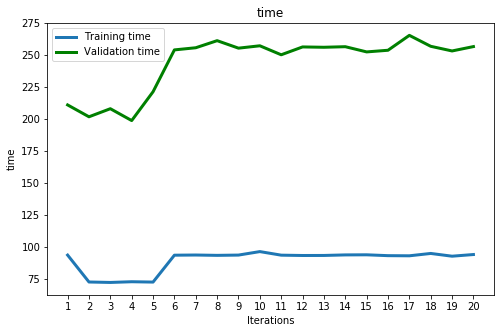

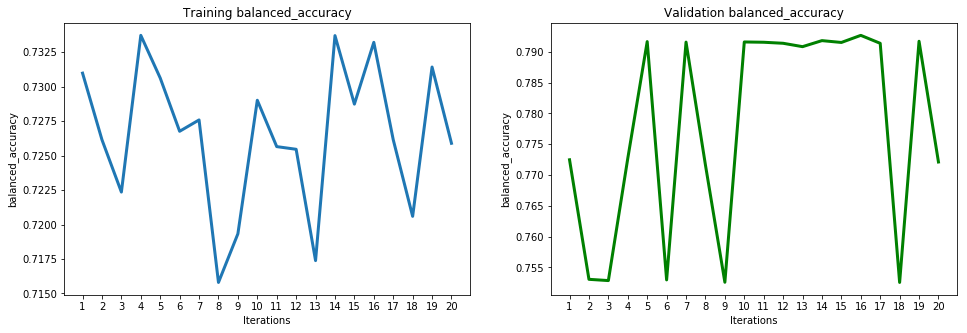

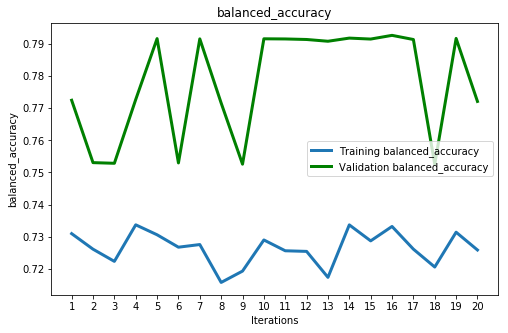

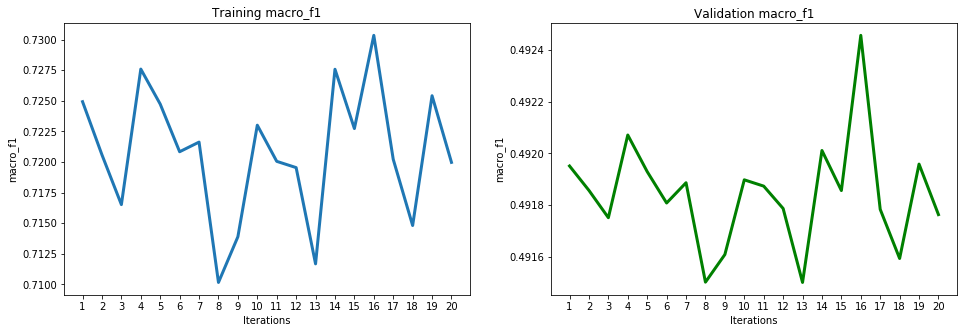

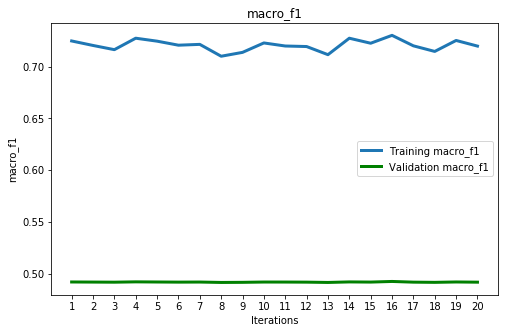

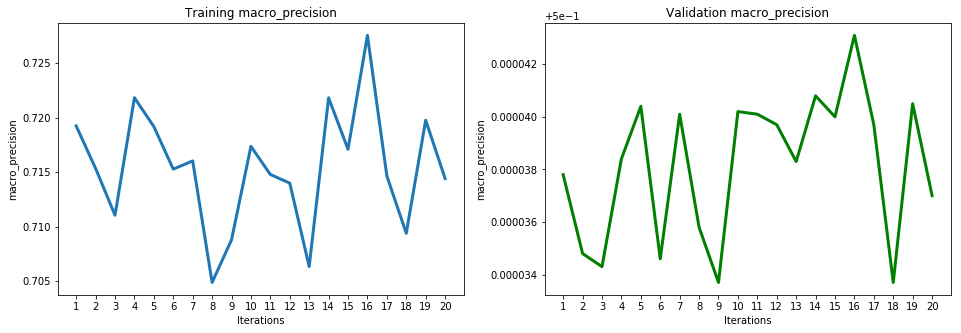

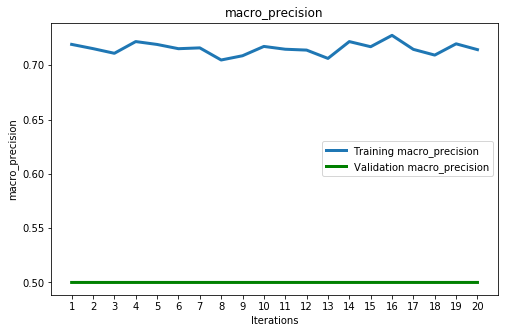

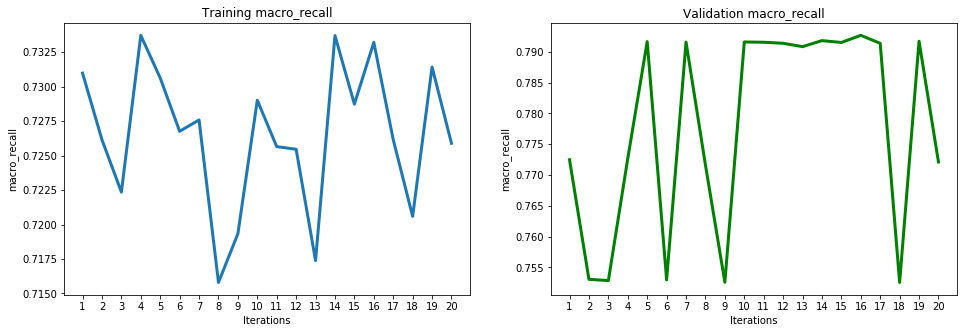

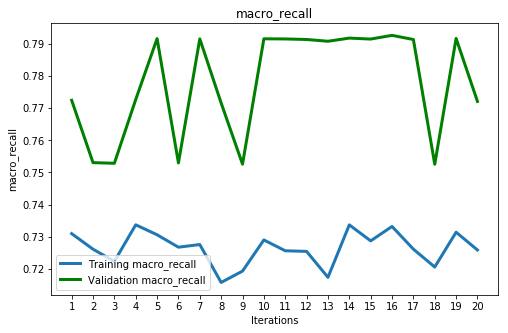

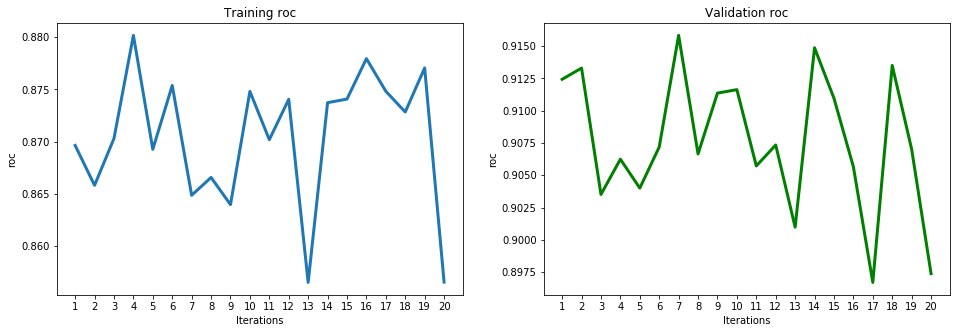

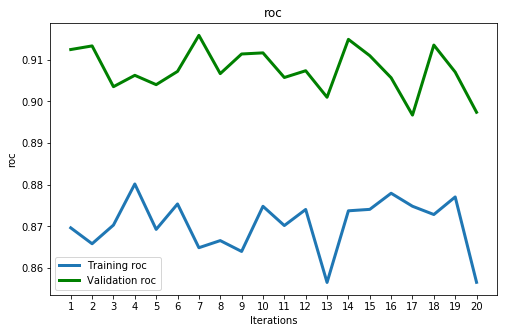

In [24]:
#metrics = ['time', 'accuracy', 'balanced_accuracy', 'f1', 'macro_f1', 'precision', 'macro_precision', 'recall', 'macro_recall', 'roc', 'macro_roc']
metrics = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
for metric in metrics:    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    plt.figure(figsize=(8, 5))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

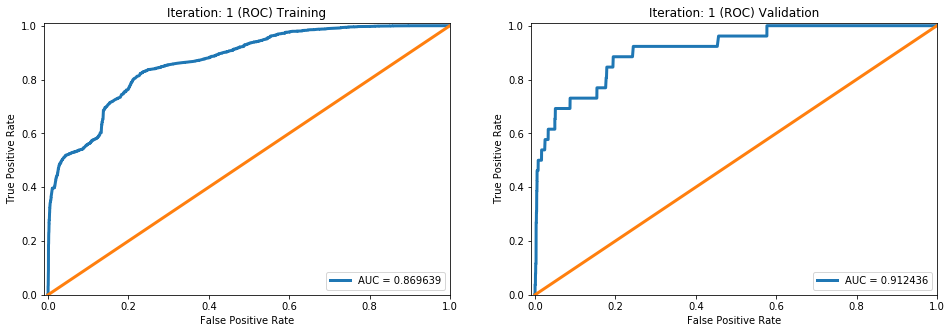

<Figure size 432x288 with 0 Axes>

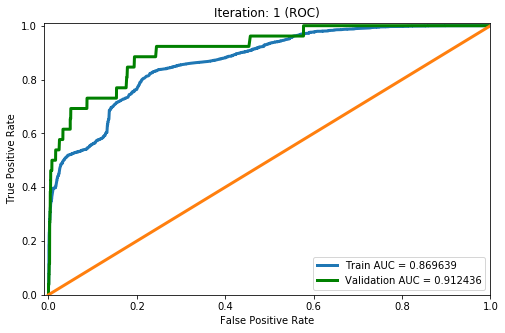

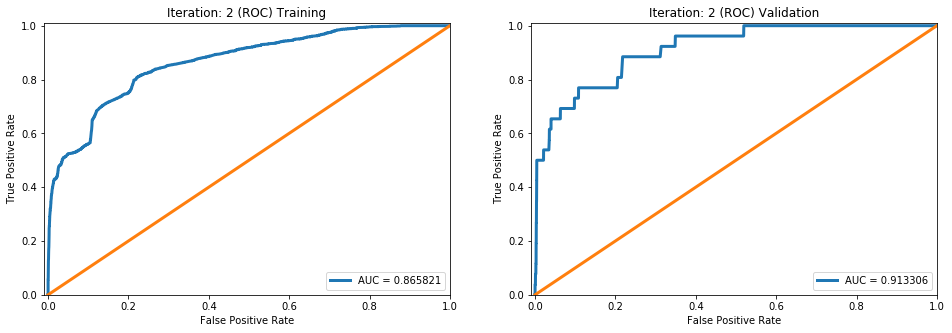

<Figure size 432x288 with 0 Axes>

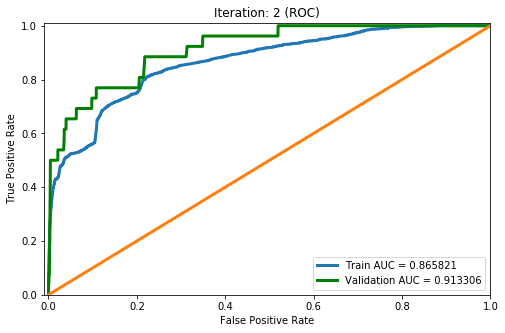

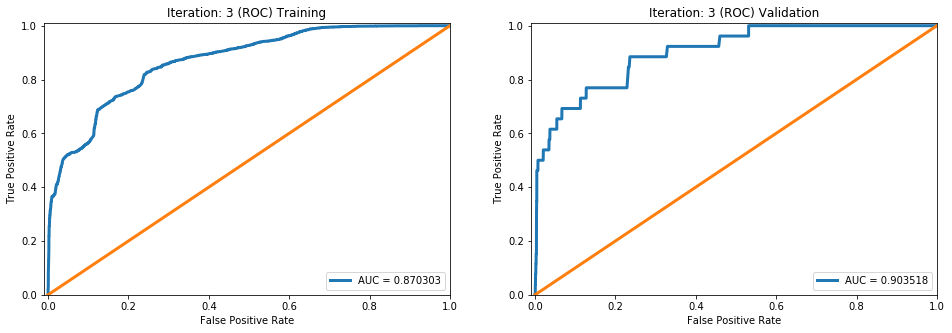

<Figure size 432x288 with 0 Axes>

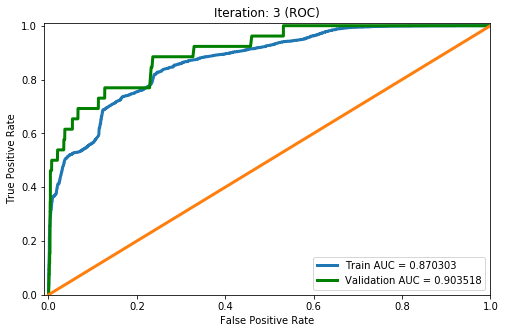

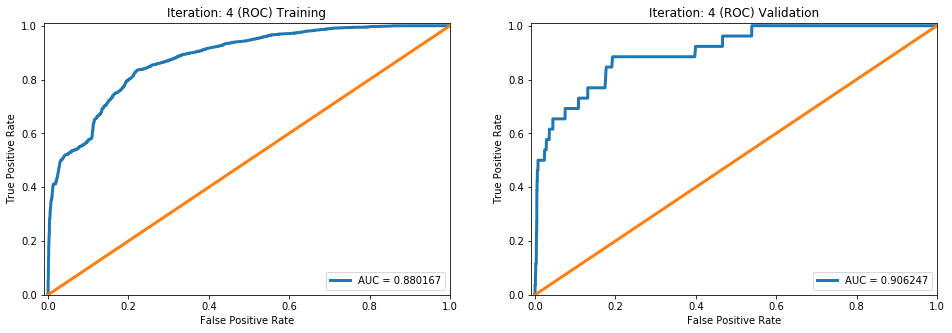

<Figure size 432x288 with 0 Axes>

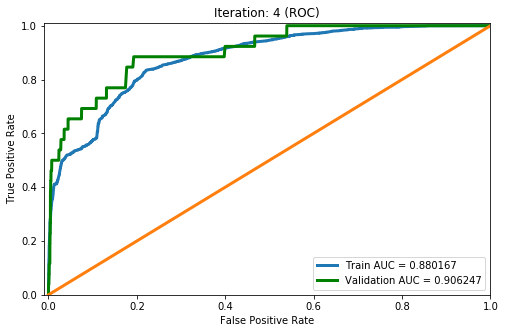

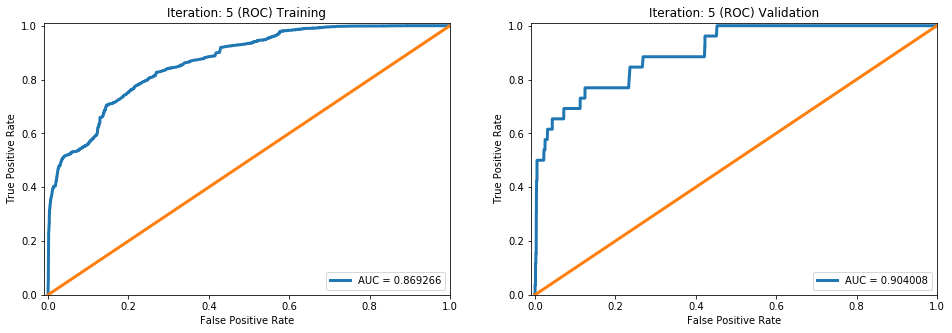

<Figure size 432x288 with 0 Axes>

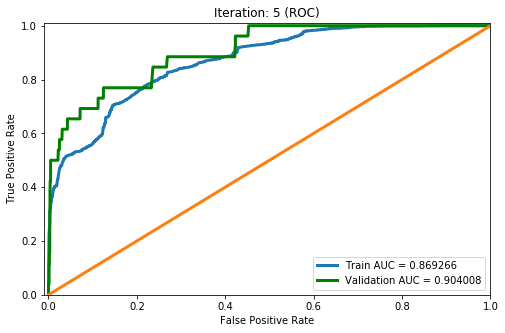

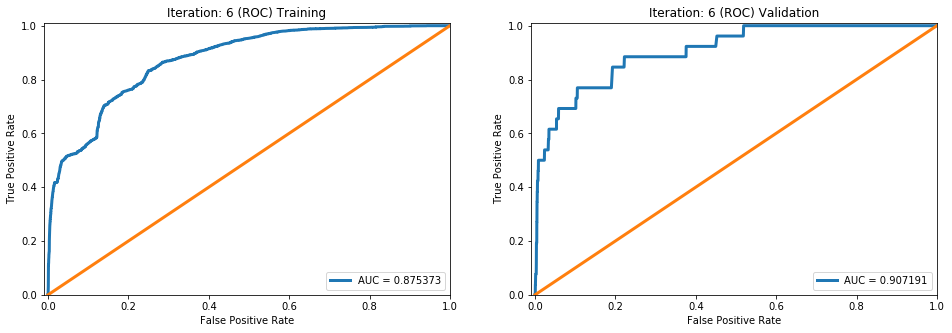

<Figure size 432x288 with 0 Axes>

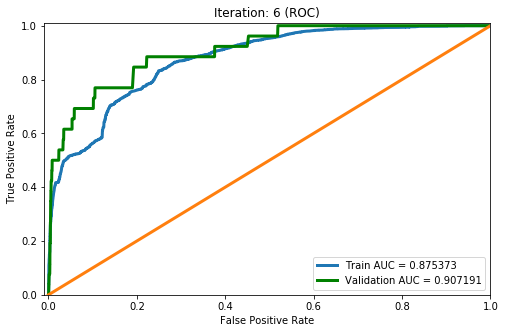

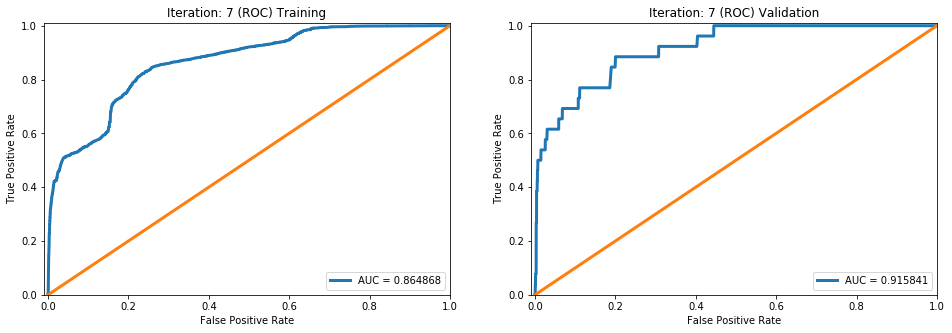

<Figure size 432x288 with 0 Axes>

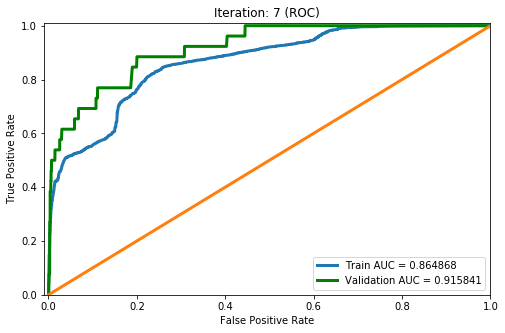

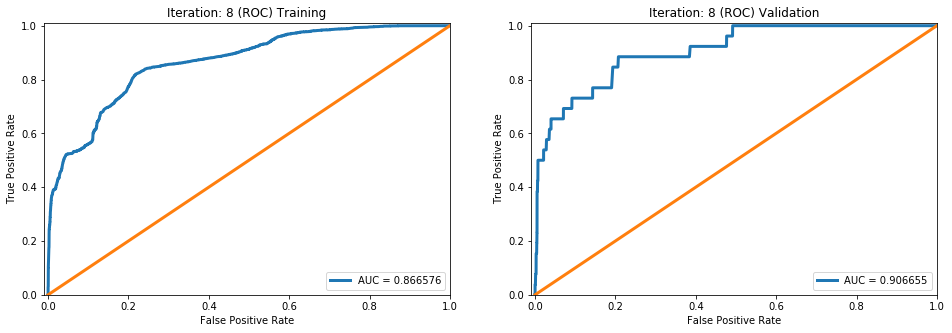

<Figure size 432x288 with 0 Axes>

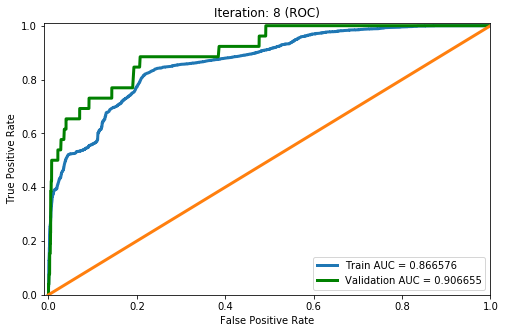

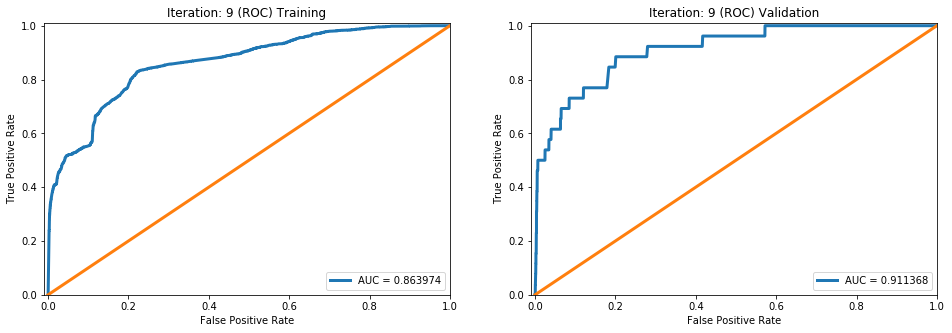

<Figure size 432x288 with 0 Axes>

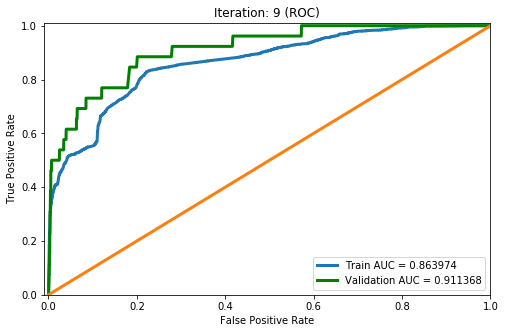

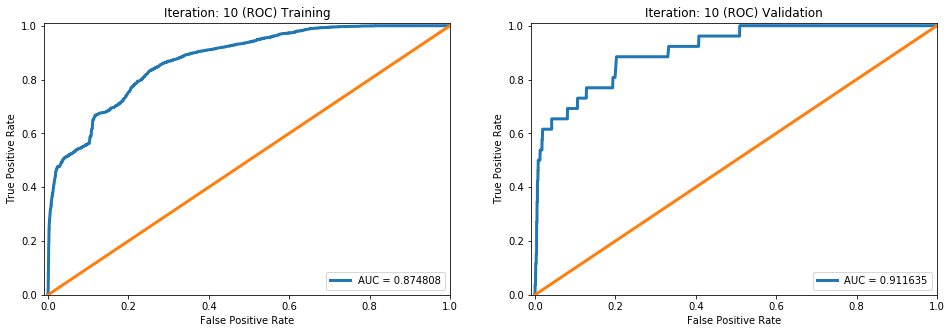

<Figure size 432x288 with 0 Axes>

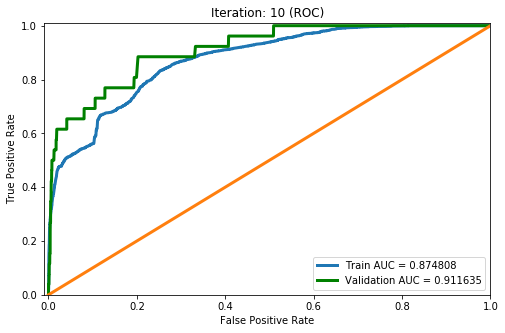

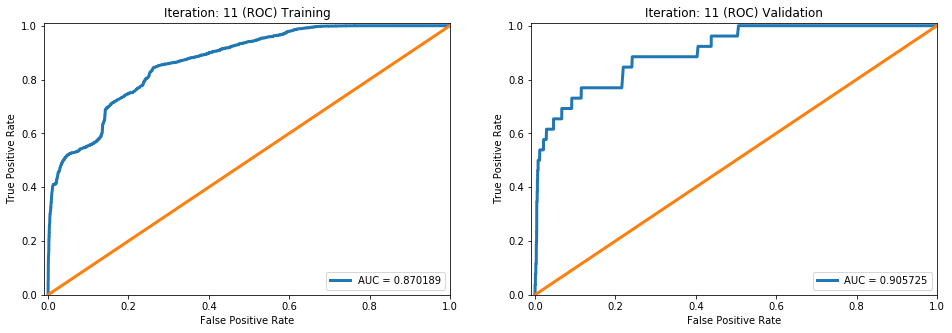

<Figure size 432x288 with 0 Axes>

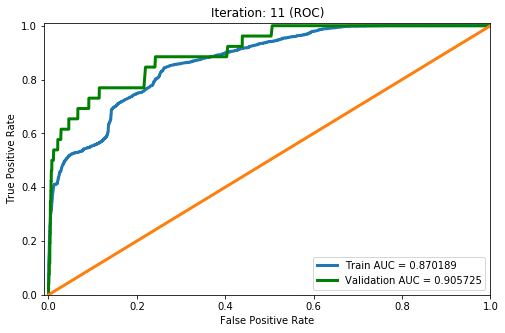

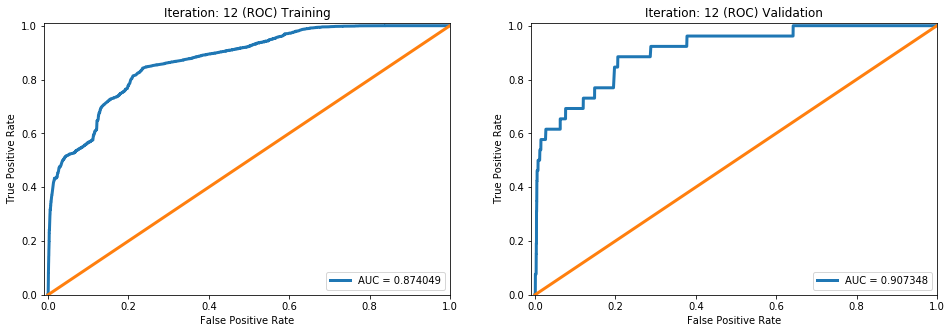

<Figure size 432x288 with 0 Axes>

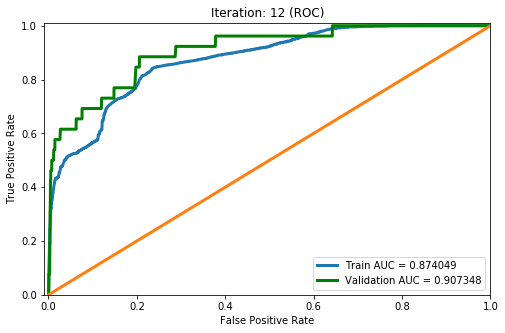

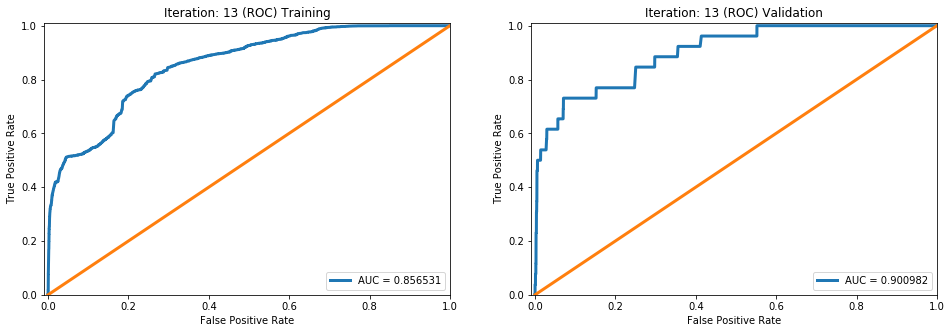

<Figure size 432x288 with 0 Axes>

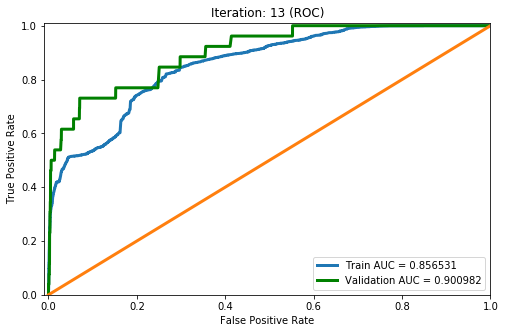

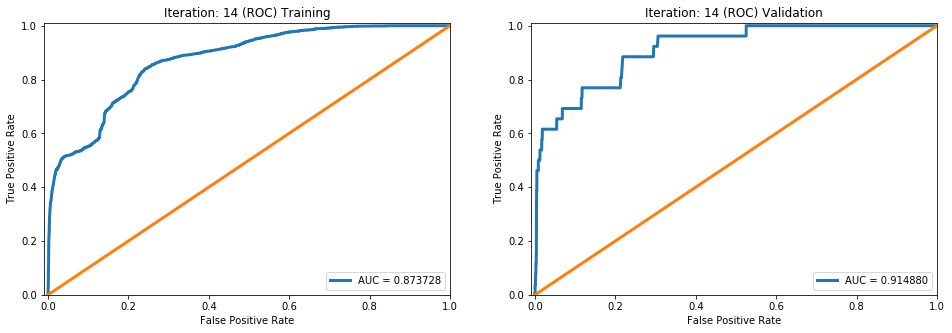

<Figure size 432x288 with 0 Axes>

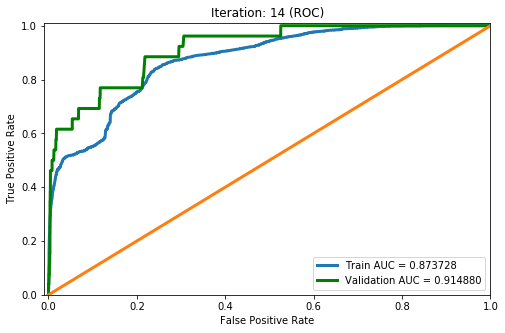

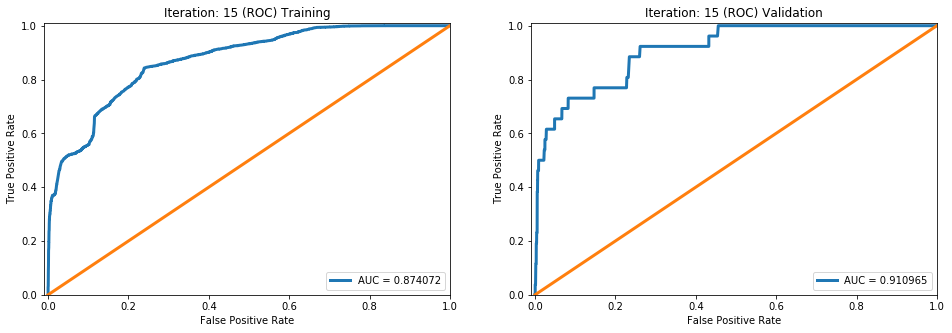

<Figure size 432x288 with 0 Axes>

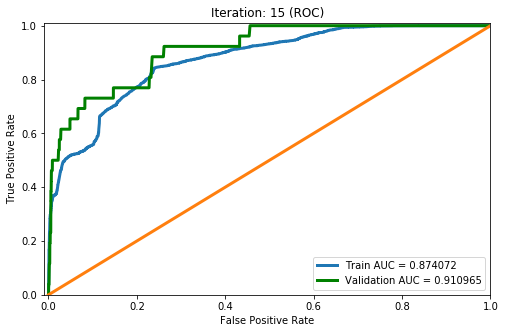

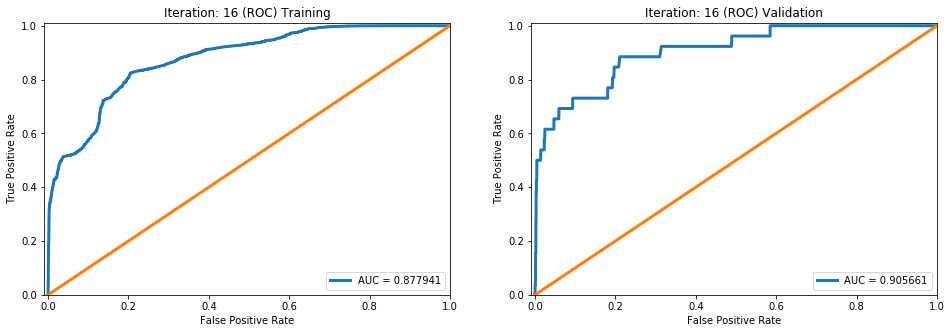

<Figure size 432x288 with 0 Axes>

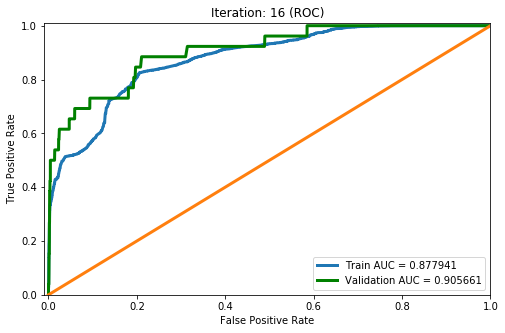

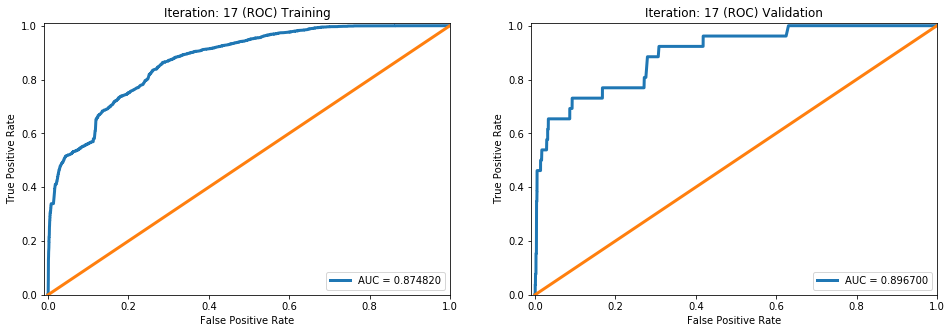

<Figure size 432x288 with 0 Axes>

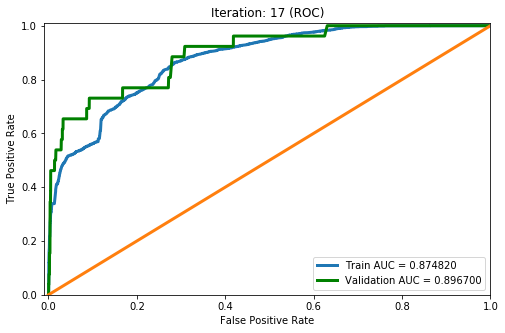

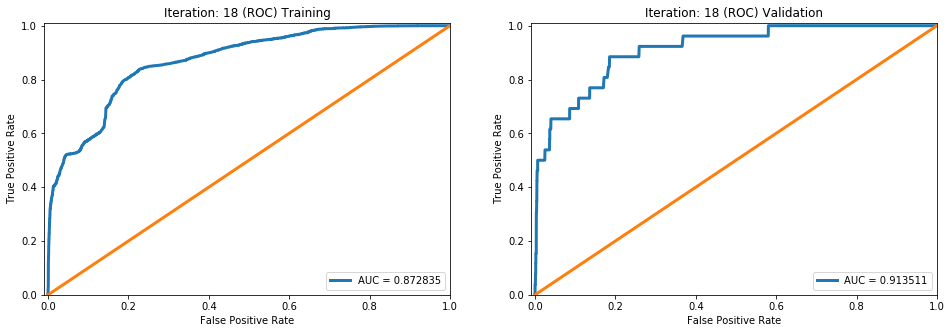

<Figure size 432x288 with 0 Axes>

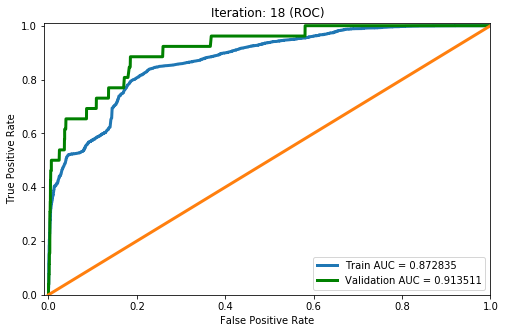

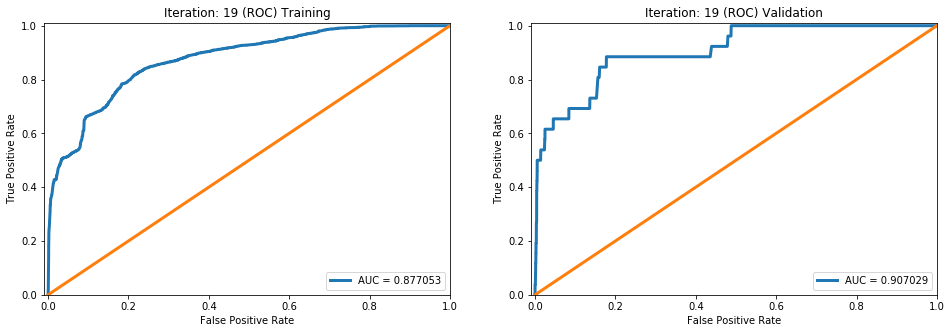

<Figure size 432x288 with 0 Axes>

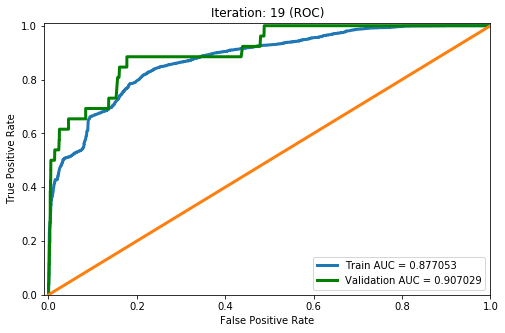

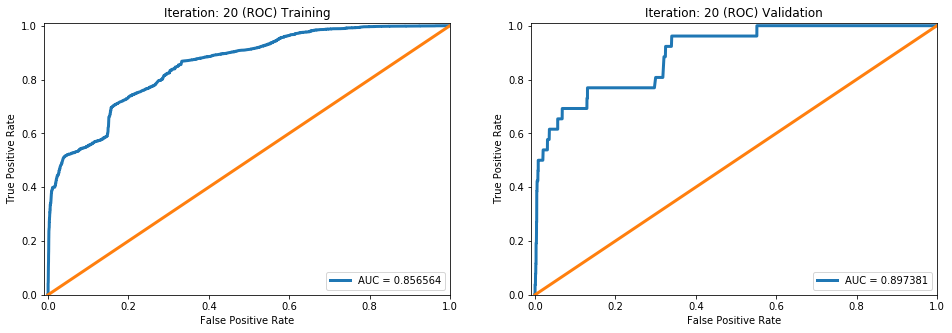

<Figure size 432x288 with 0 Axes>

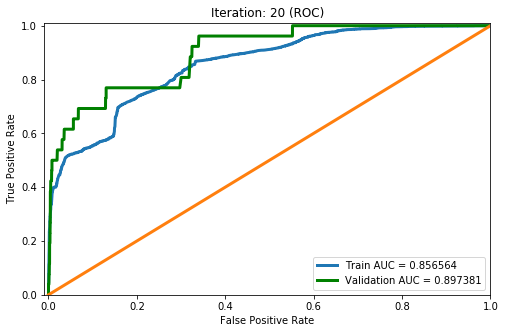

In [25]:
for it in iterations:
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
    ax1.plot([0,1],[0,1], linewidth=3)

    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    
    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)
    
    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
    ax2.plot([0,1],[0,1], linewidth=3)

    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.figure(2)
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    plt.figure(figsize=(8, 5))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
    plt.plot([0,1],[0,1], linewidth=3)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

    plt.legend(loc='lower right')
    plt.title('Iteration: '+ str(it) +' (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

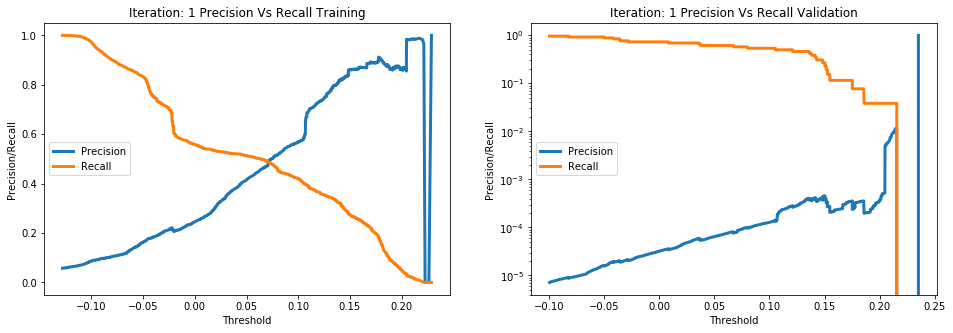

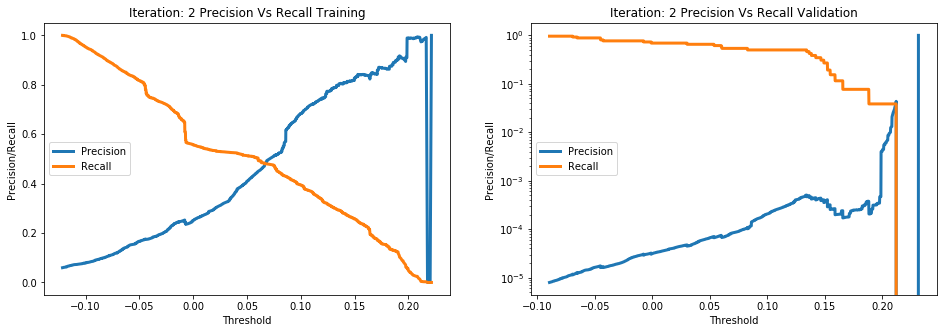

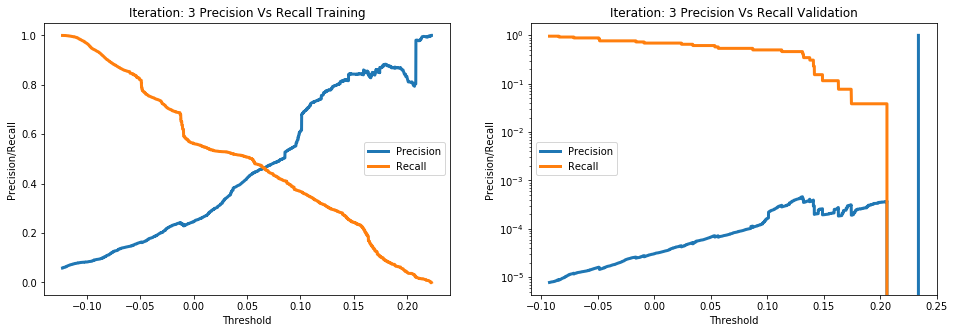

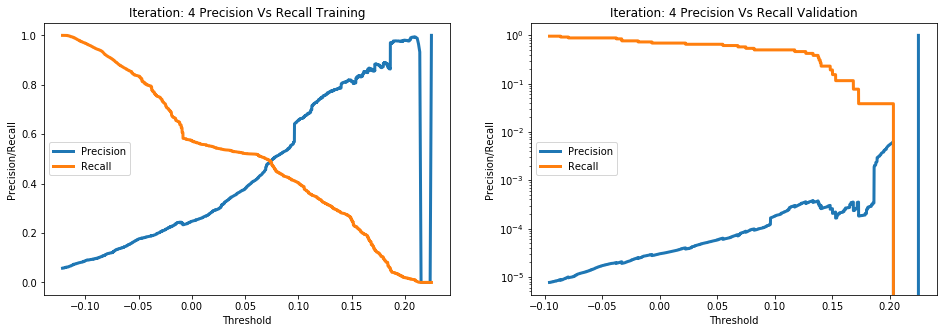

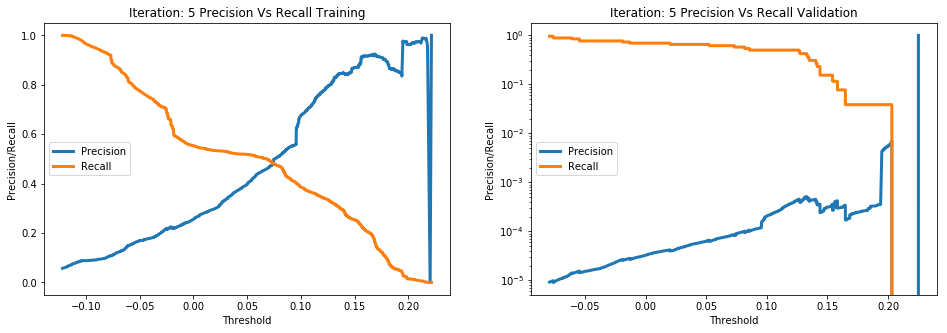

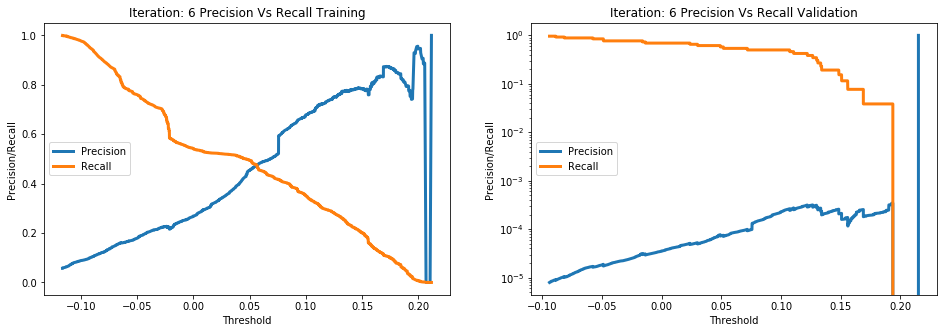

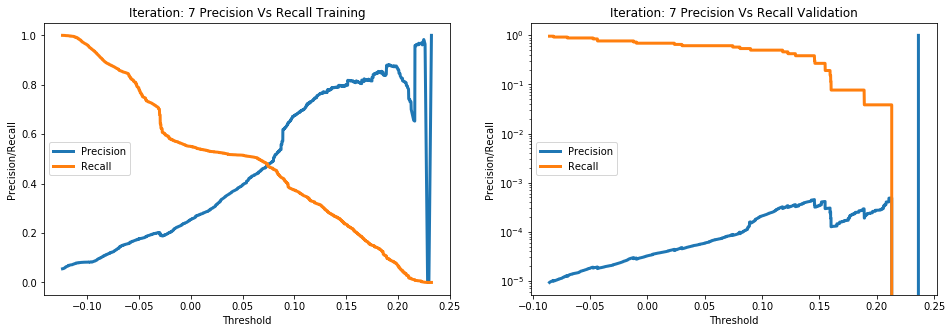

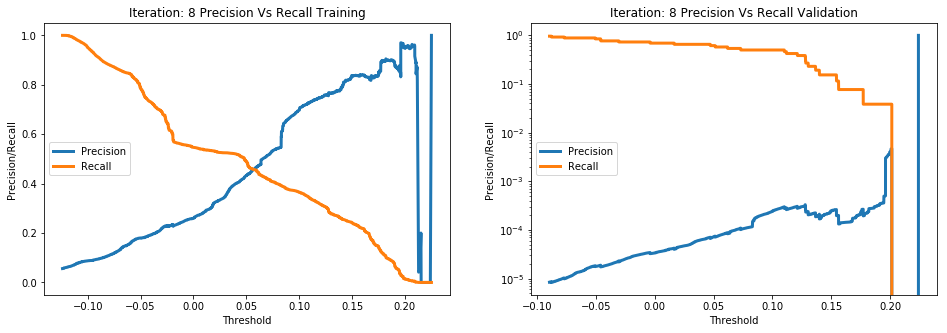

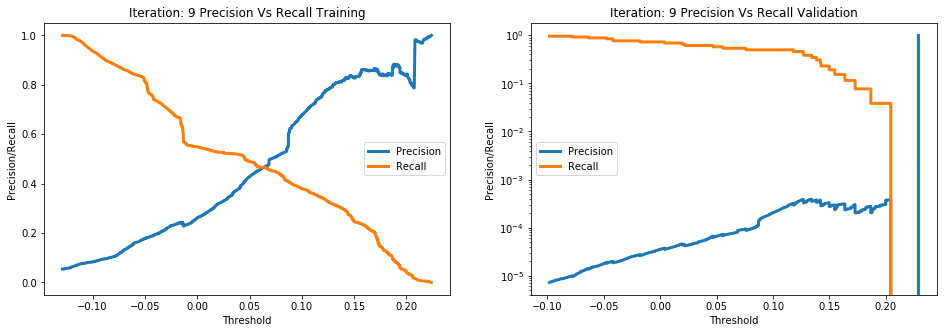

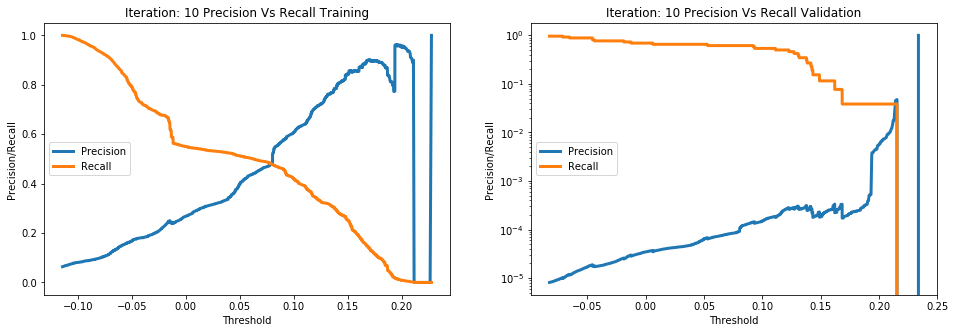

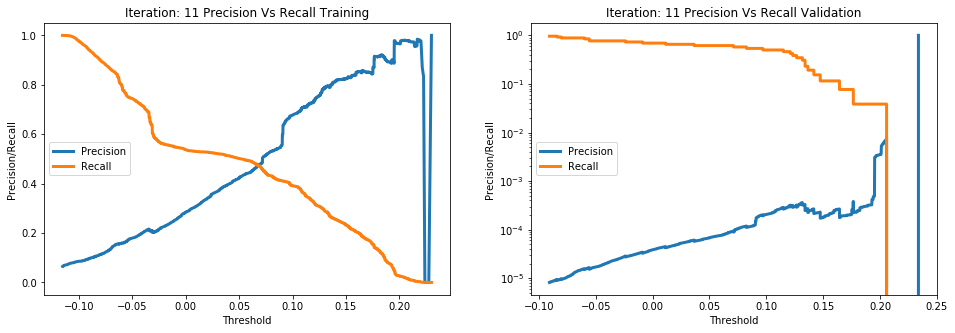

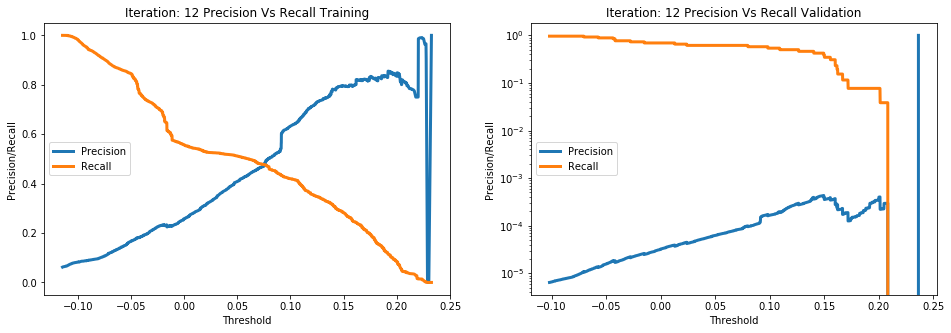

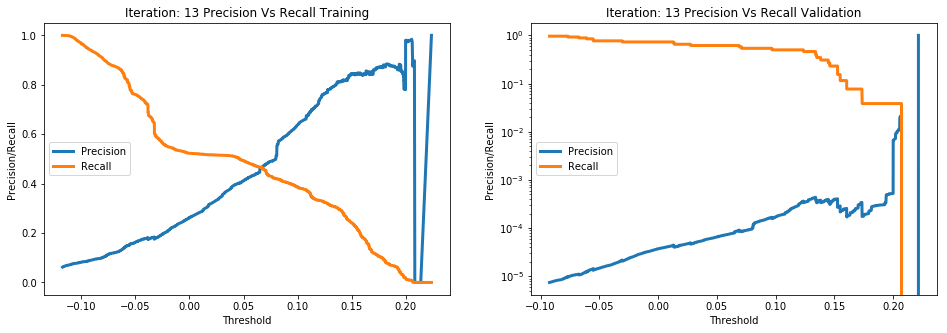

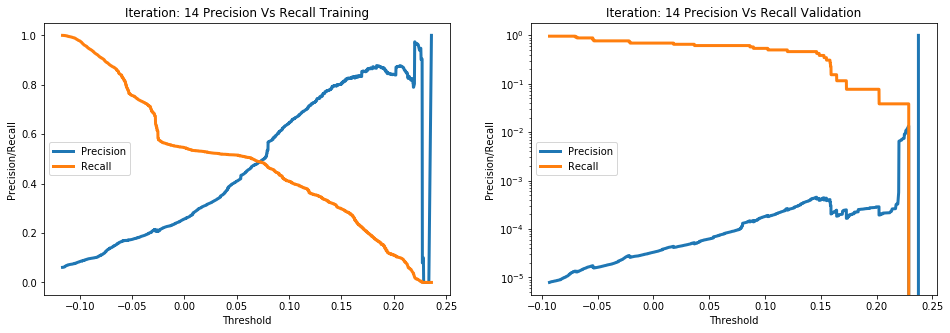

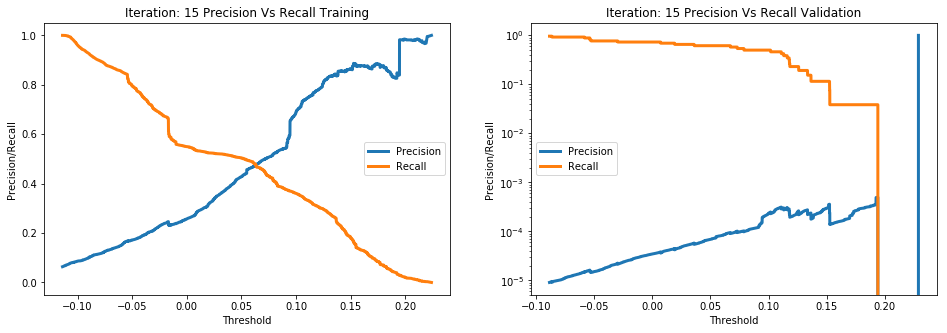

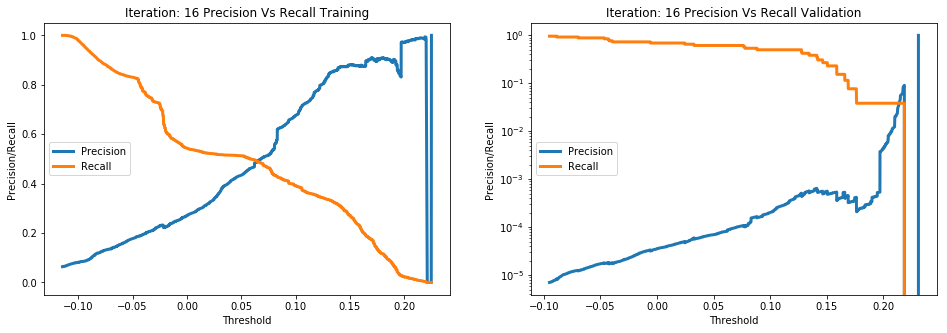

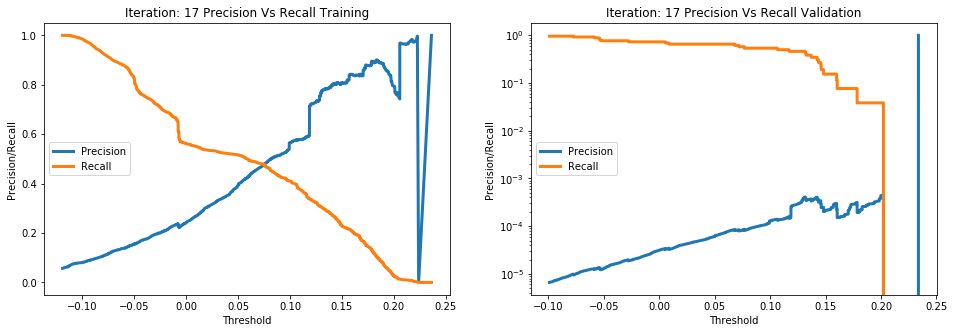

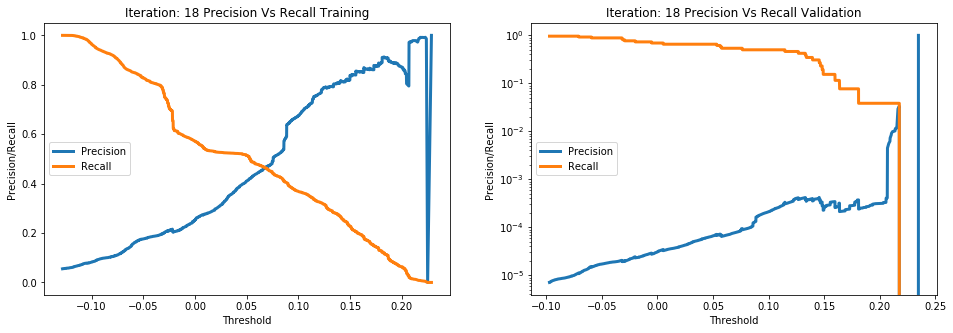

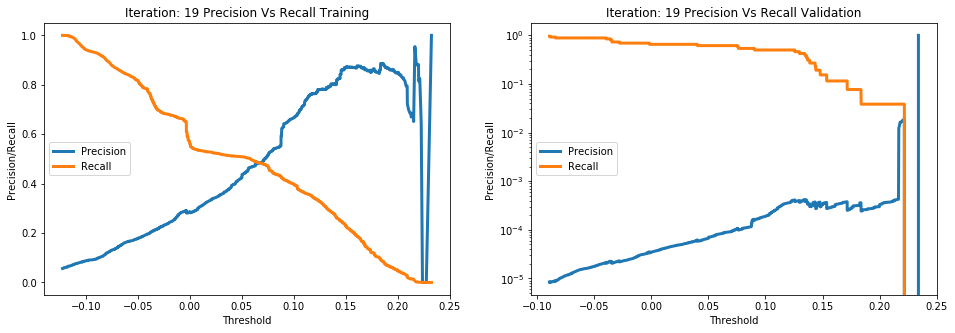

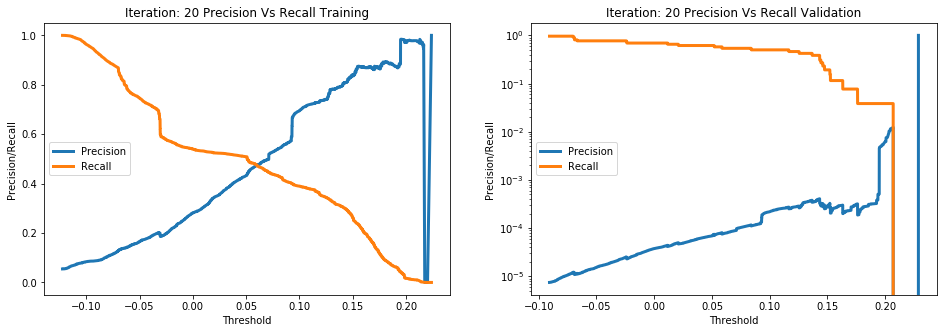

In [26]:
for it in iterations:
    precision_rt = training_evaluations[it]['precision_rt']
    recall_rt = training_evaluations[it]['recall_rt']
    threshold_rate = training_evaluations[it]['threshold_rt']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
    ax1.set_ylabel('Precision/Recall')
    ax1.set_xlabel('Threshold')
    
    
    precision_rt = test_evaluations[it]['precision_rt']
    recall_rt = test_evaluations[it]['recall_rt']
    threshold_rate = test_evaluations[it]['threshold_rt']
    ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
    ax2.set_ylabel('Precision/Recall')
    ax2.set_xlabel('Threshold')

# Confusion Matrix

In [27]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [28]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

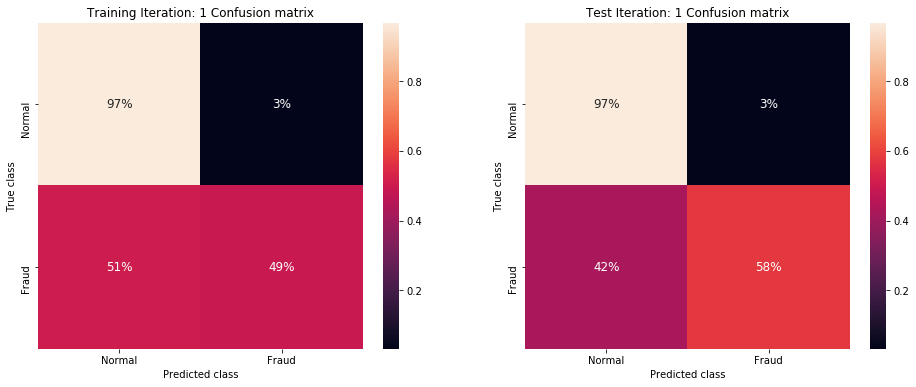

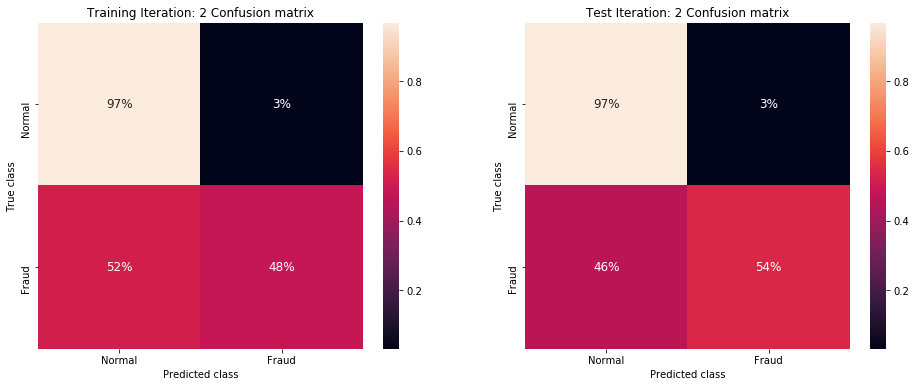

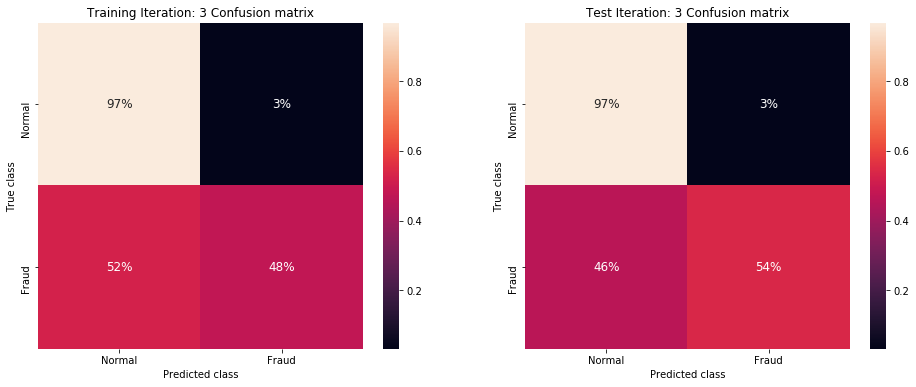

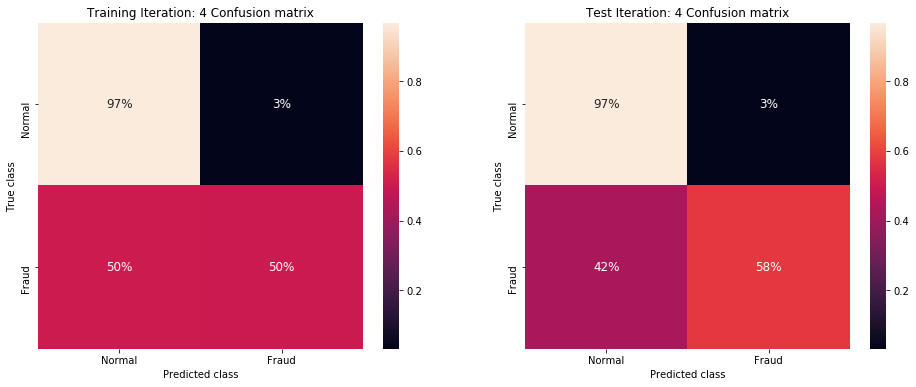

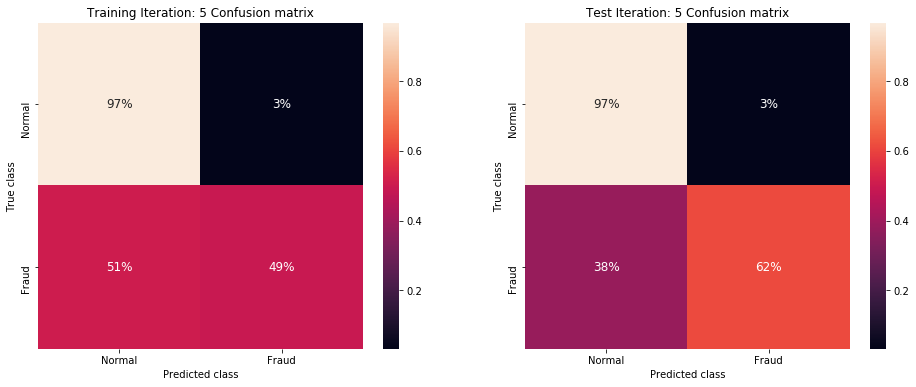

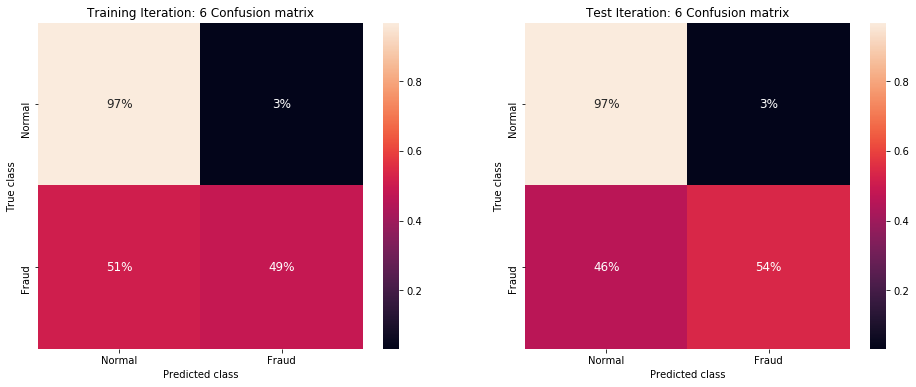

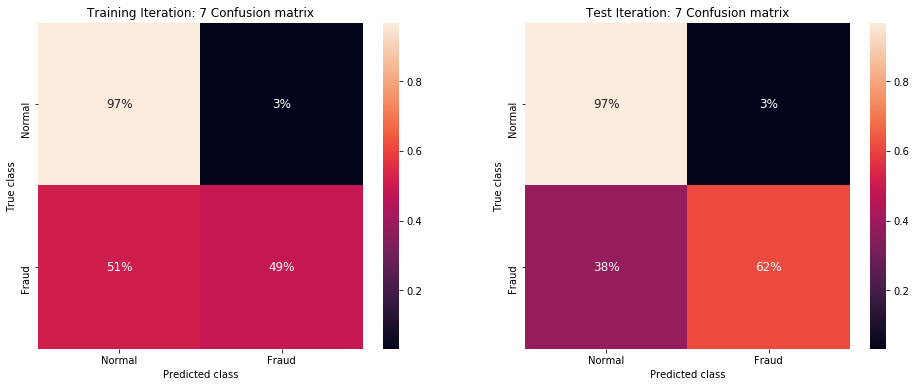

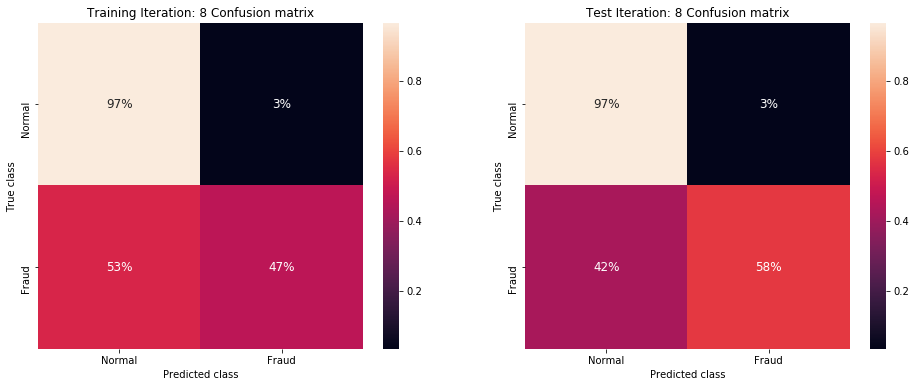

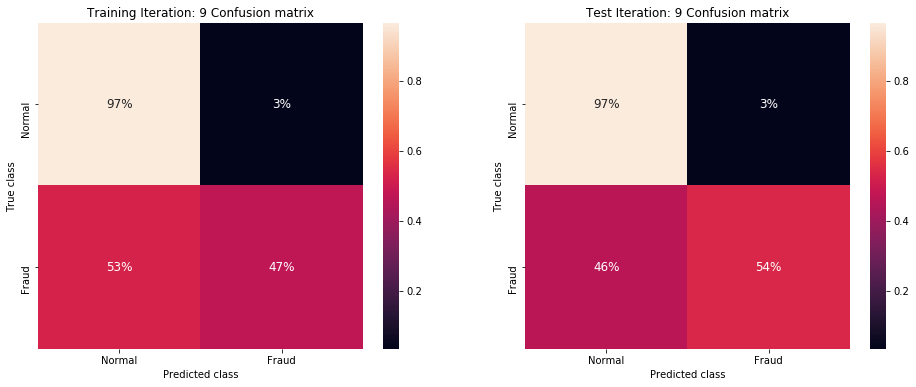

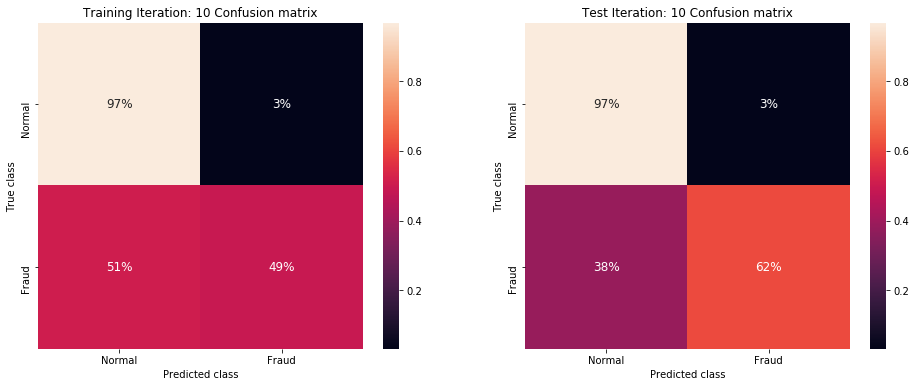

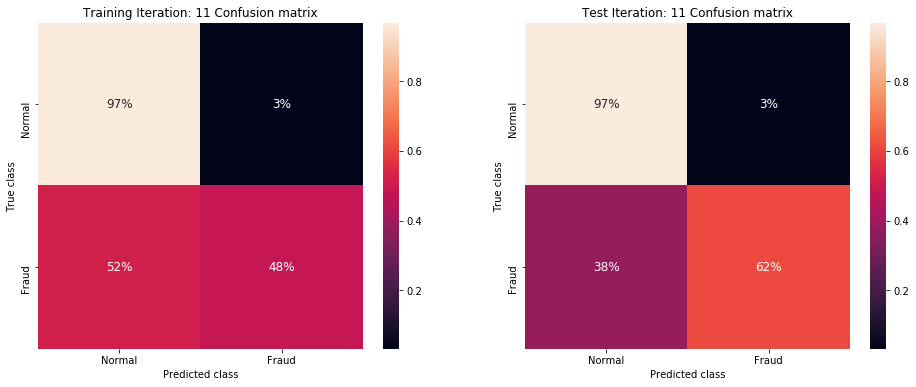

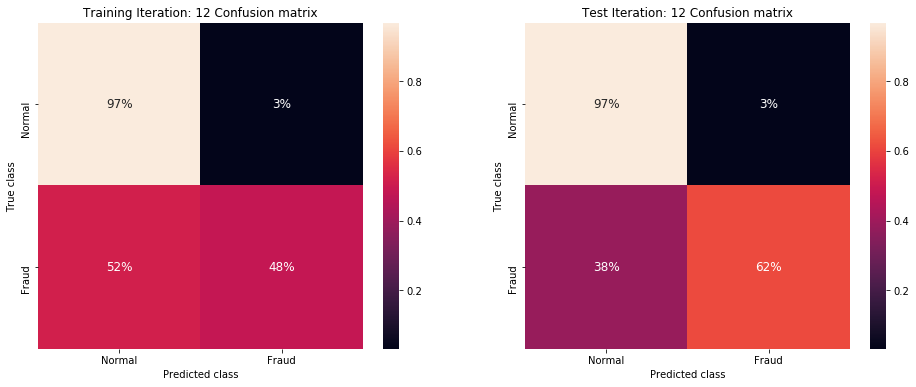

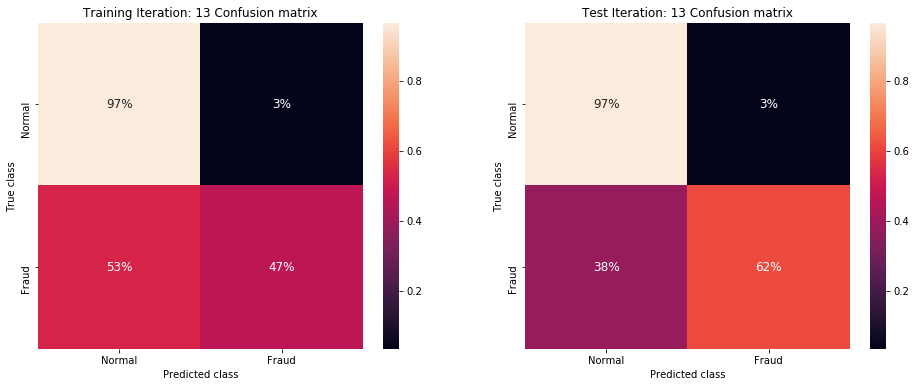

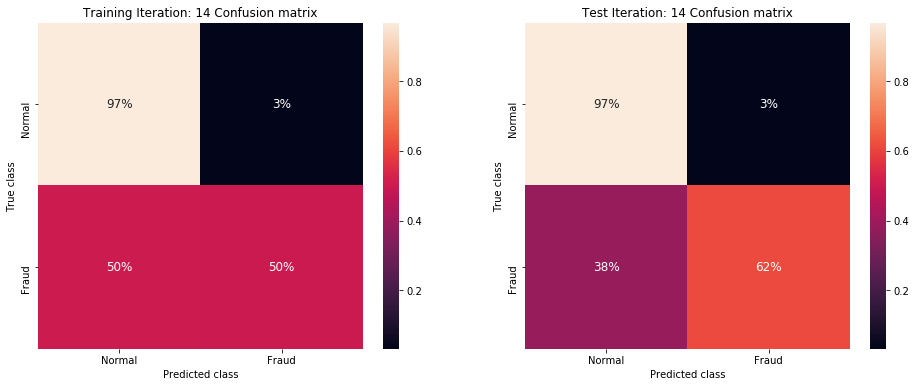

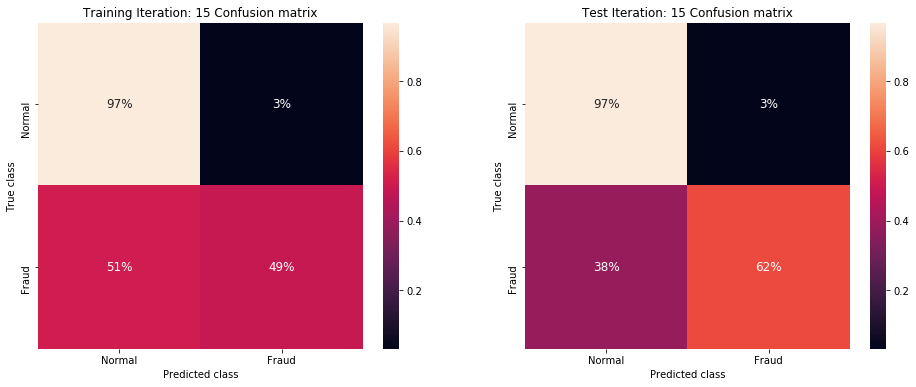

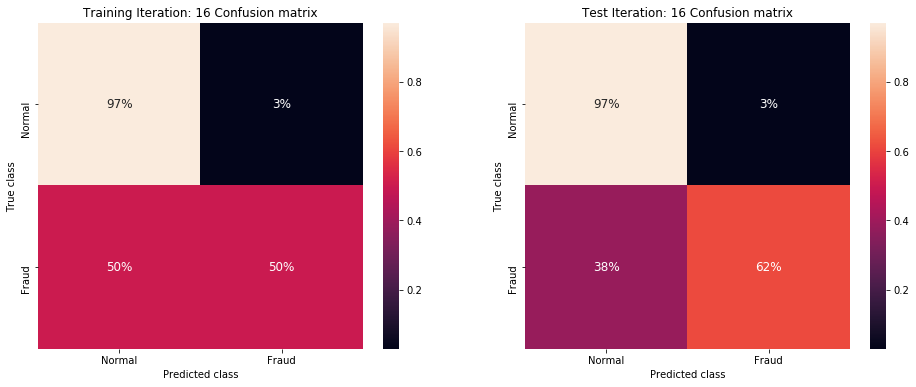

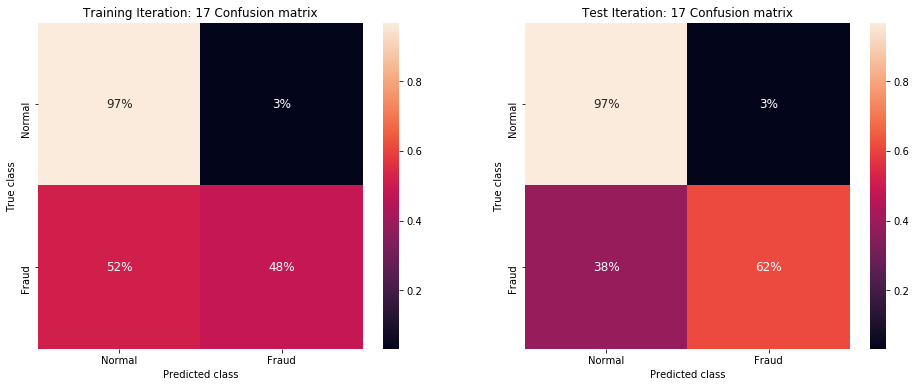

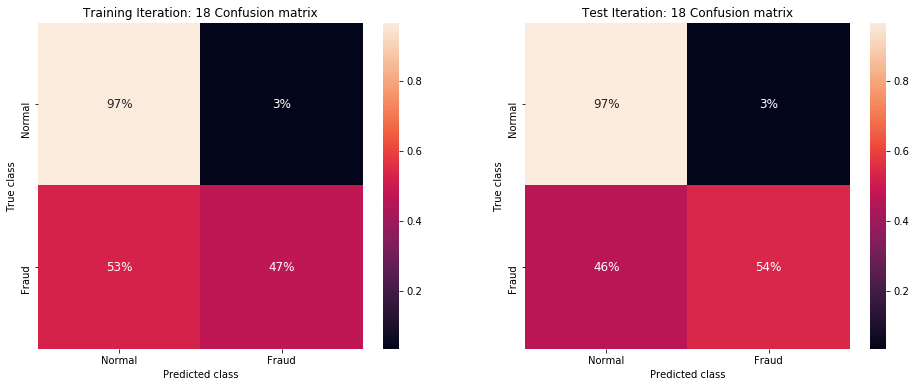

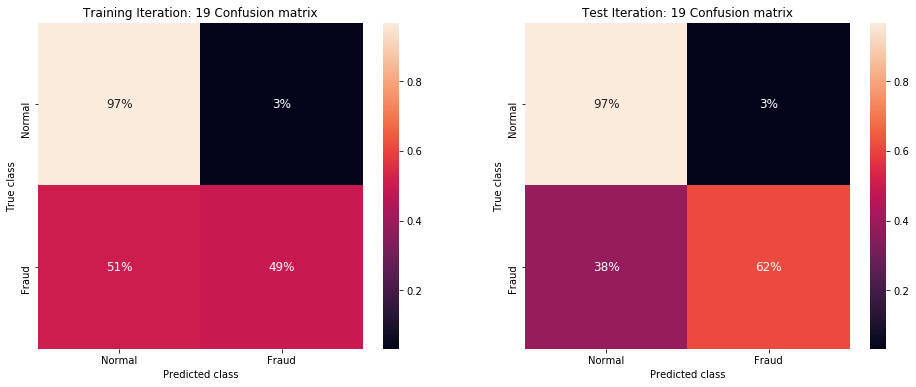

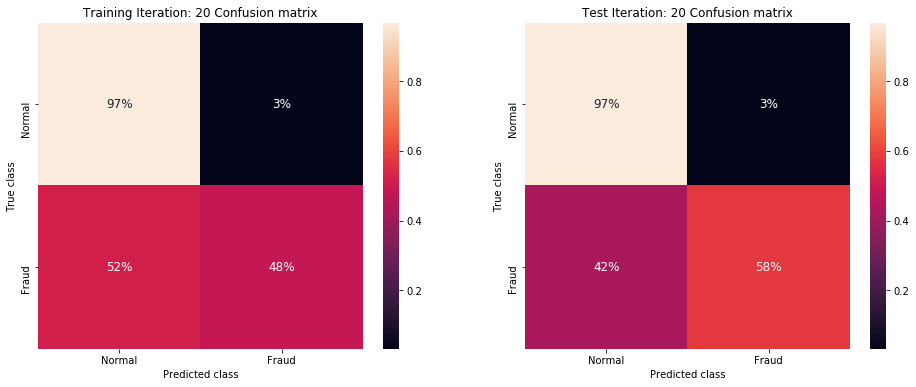

In [29]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

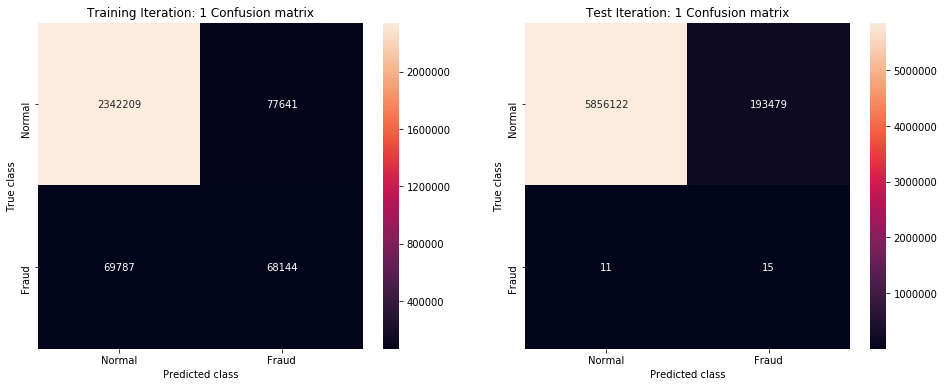

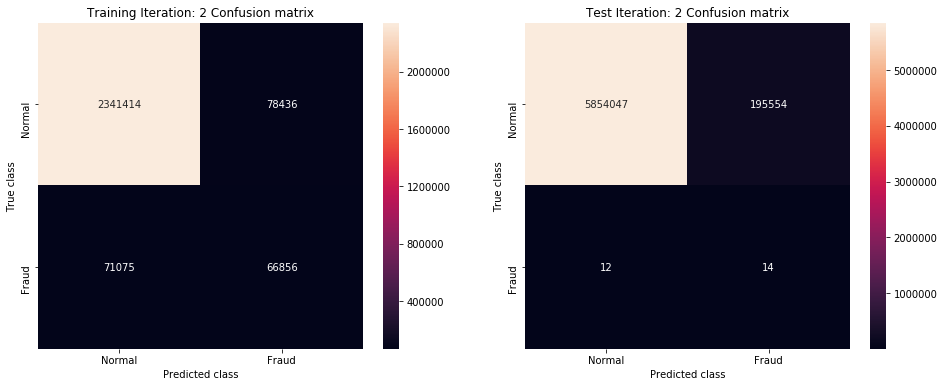

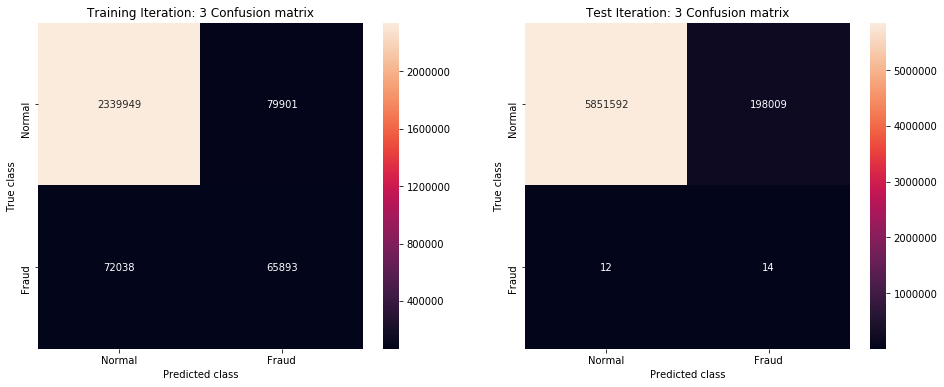

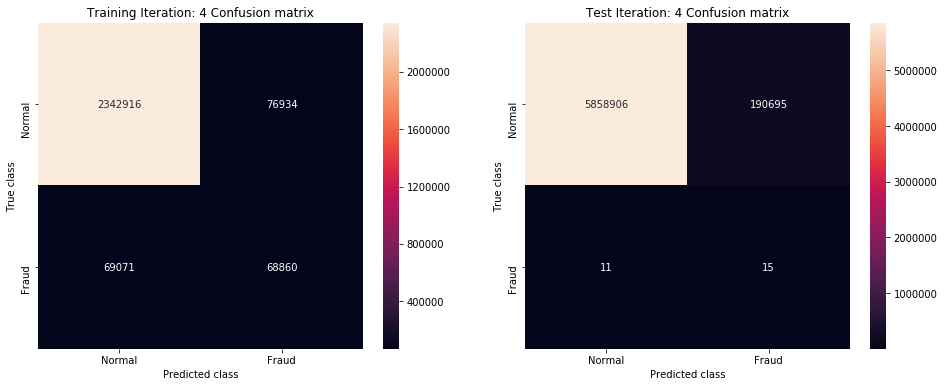

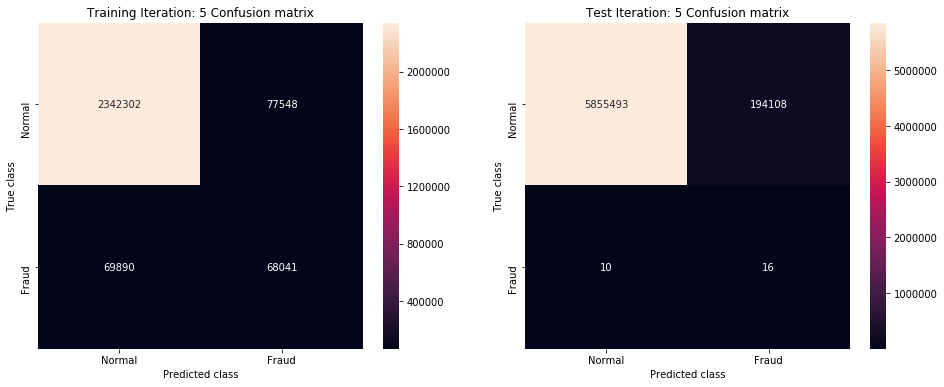

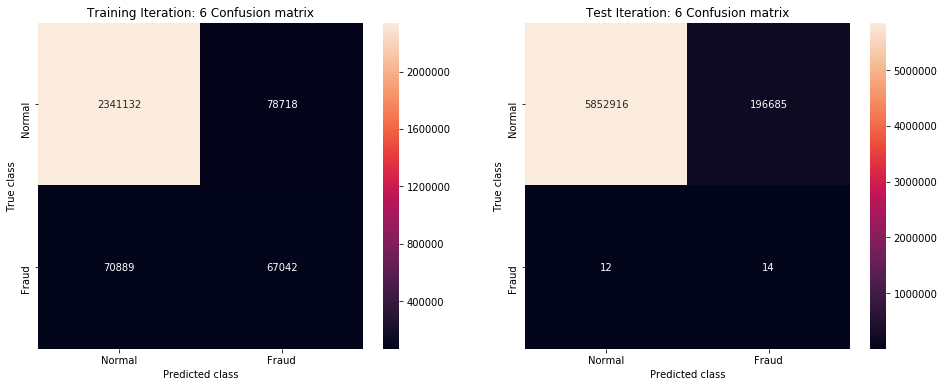

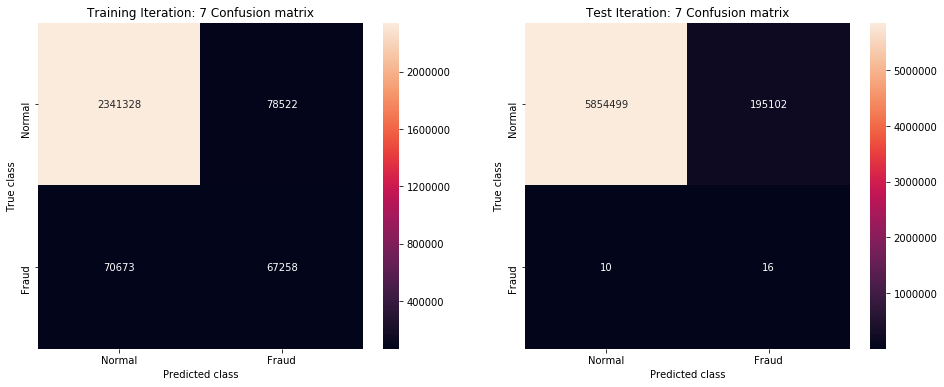

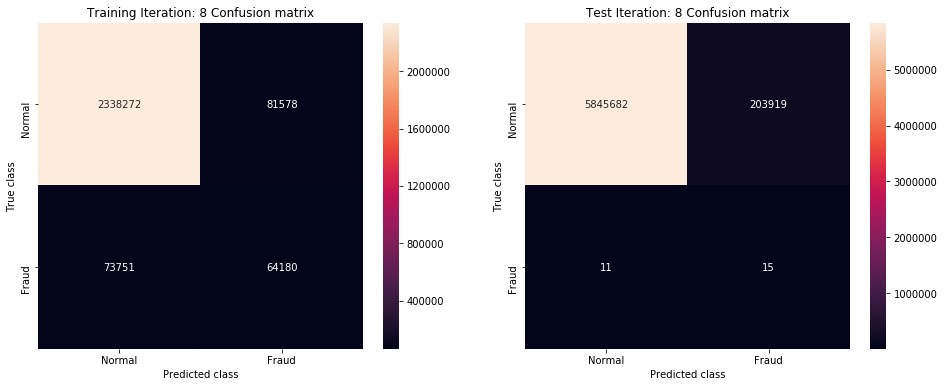

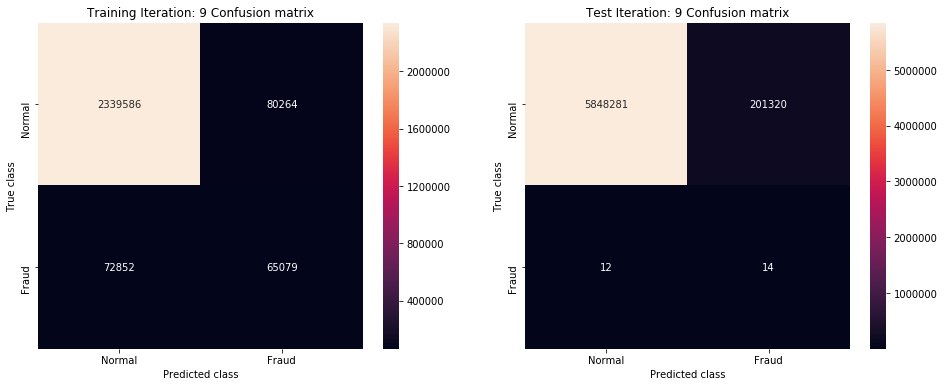

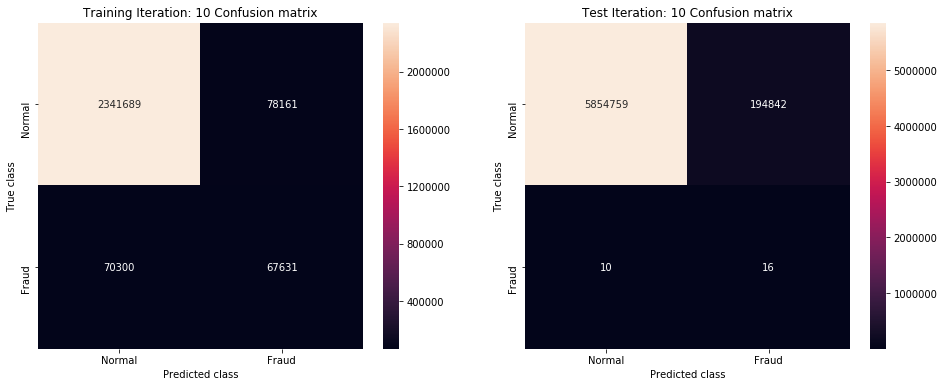

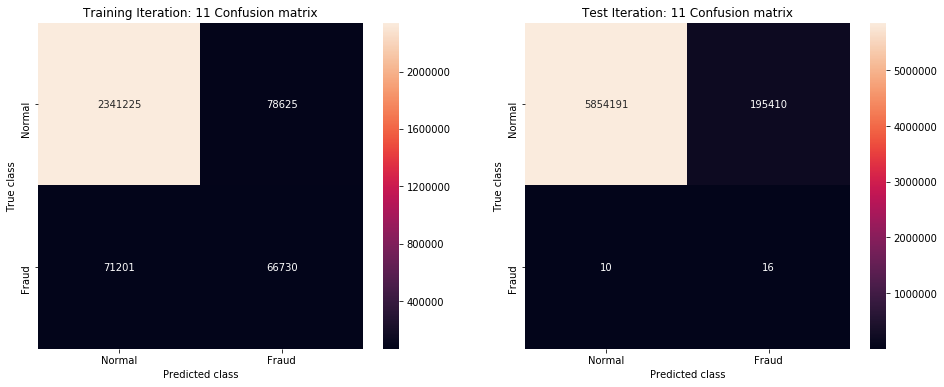

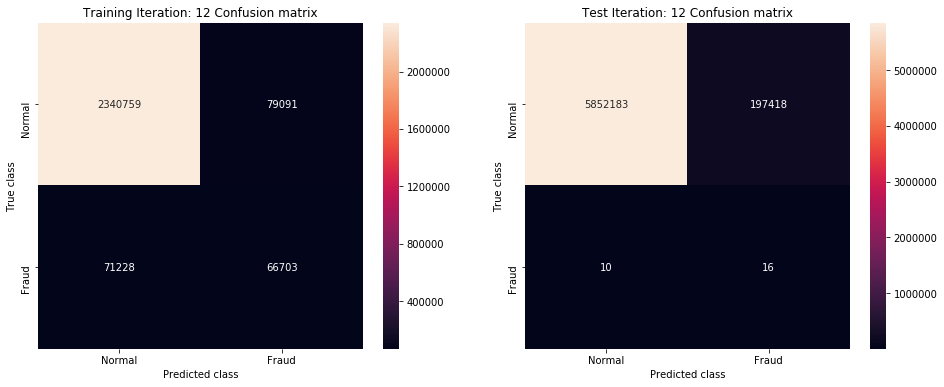

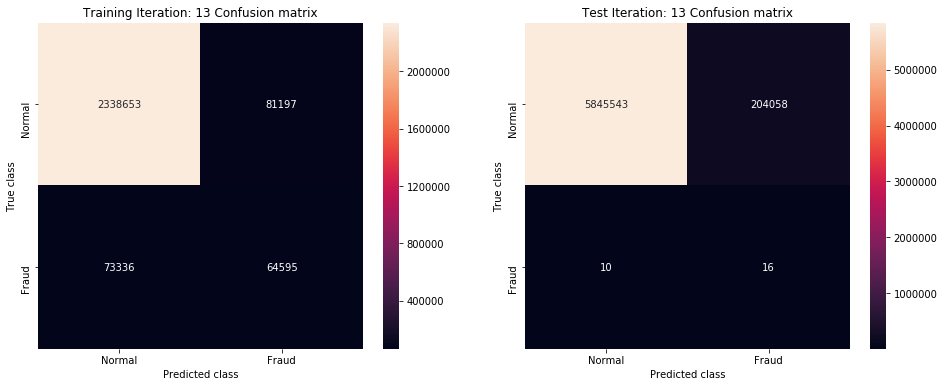

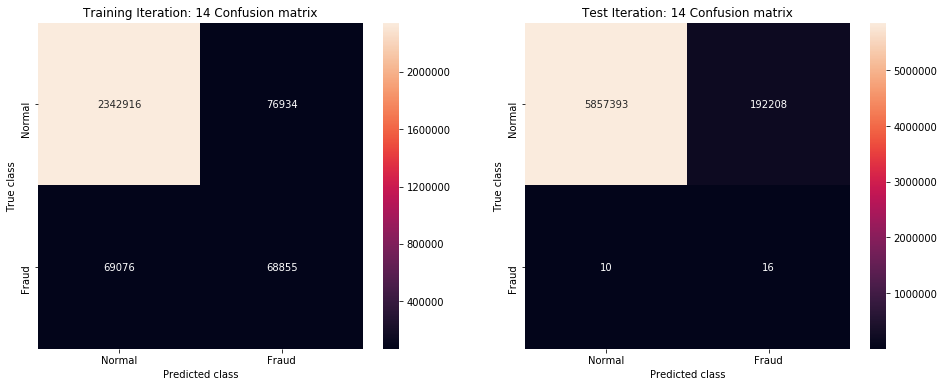

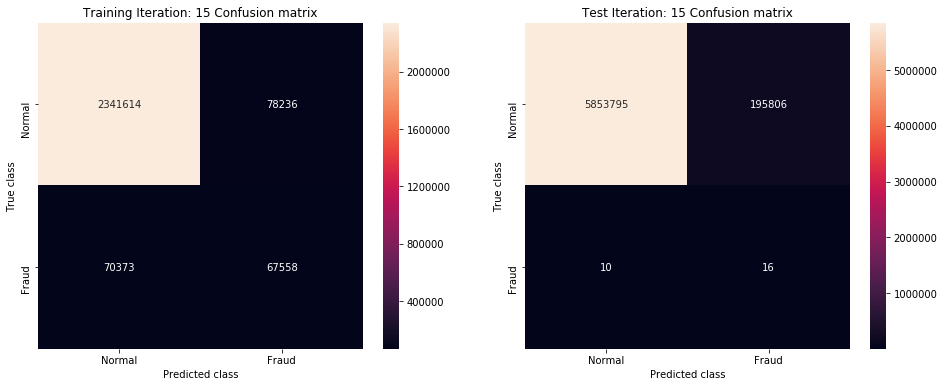

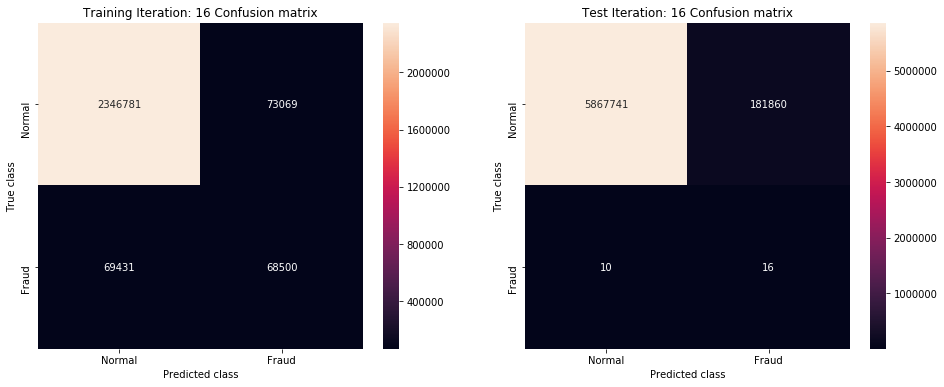

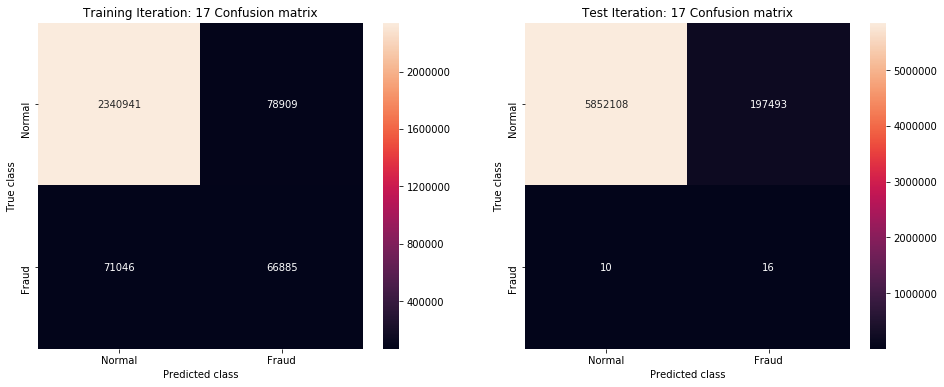

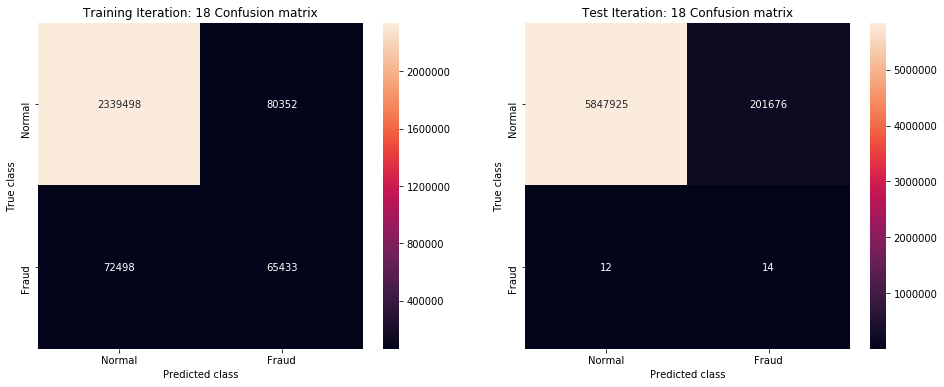

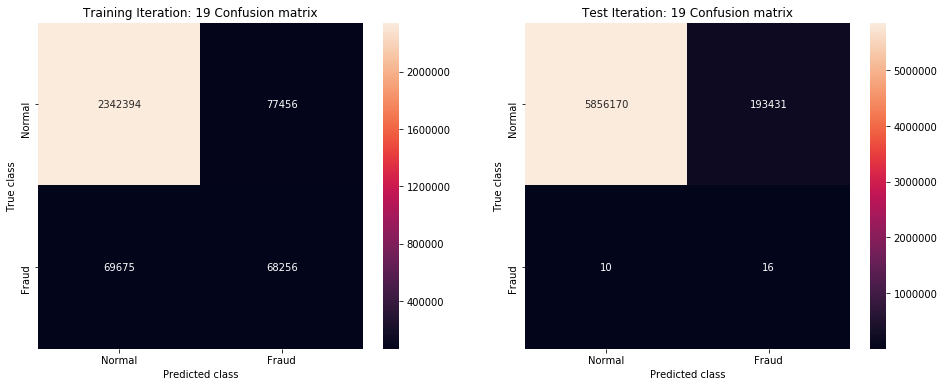

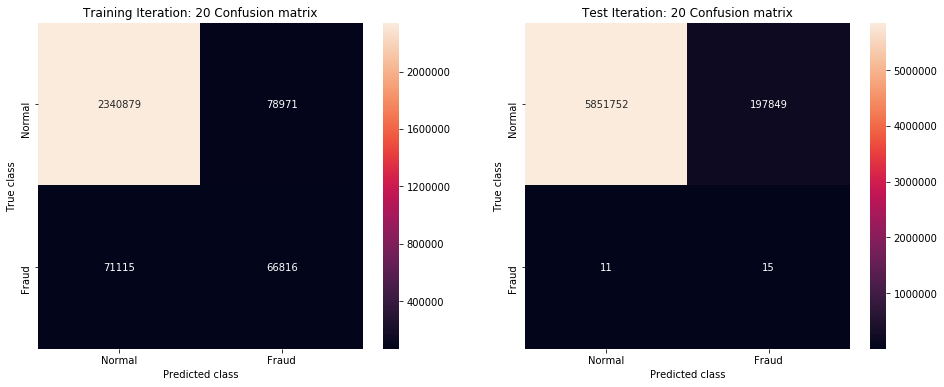

In [30]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, it)

# Parameter Tuning

In [31]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

space={
'n_estimators': hp.uniform('n_estimators', 5, 100),
'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25)
}

random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
print('Training With:')
print(pd.value_counts(sample_ytrain))


def hyper_parm_opt(space):
    start = time.time()
    n_estimators = int(space['n_estimators'])
    outliers_fraction = space['outliers_fraction']
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = IForest(n_estimators=n_estimators, contamination=outliers_fraction, random_state=random_state, n_jobs=-1)
    clf.fit(X_train)
    y_train_pred = clf.labels_
    score = f1_score(y_train, y_train_pred, average="macro")
    val = 1 - score
    end = time.time()
    print('time: ' + str(round(end - start, 4)) + ' seconds')
    print('params: '+ str(space))
    print('val: ' + str(val))
    print('')
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=100, trials=trials)


print('\n\n\nbest: {}'.format(best))

Training With:
0    2419850
1         82
dtype: int64
time: 130.6316 seconds
params: {'n_estimators': 57.701007478038804, 'outliers_fraction': 0.18932713311227095}
val: 0.2949633520337276

time: 119.5463 seconds
params: {'n_estimators': 53.675067239310124, 'outliers_fraction': 0.19818631514068014}
val: 0.3014213969822497

time: 60.8941 seconds
params: {'n_estimators': 30.110861929254092, 'outliers_fraction': 0.1501184644433098}
val: 0.2940371719610142

time: 55.9427 seconds
params: {'n_estimators': 28.655361159596133, 'outliers_fraction': 0.1288402990710344}
val: 0.2887827464186493

time: 74.601 seconds
params: {'n_estimators': 34.941054724288946, 'outliers_fraction': 0.21852352112402906}
val: 0.29837717201604097

time: 75.6352 seconds
params: {'n_estimators': 41.41713938624594, 'outliers_fraction': 0.07160454871669555}
val: 0.28334145197296834

time: 104.6877 seconds
params: {'n_estimators': 52.282684703290506, 'outliers_fraction': 0.16734872760990527}
val: 0.2919388695425502

time: 1

time: 163.4031 seconds
params: {'n_estimators': 63.60763611891875, 'outliers_fraction': 0.17658484151169063}
val: 0.2899903971927884

time: 161.5039 seconds
params: {'n_estimators': 69.10567702848874, 'outliers_fraction': 0.06855869717836723}
val: 0.273225183319626

time: 177.2961 seconds
params: {'n_estimators': 74.68237861732919, 'outliers_fraction': 0.08117242584444774}
val: 0.27270880874844017

time: 262.1453 seconds
params: {'n_estimators': 93.22540737281172, 'outliers_fraction': 0.19673489108587655}
val: 0.30012853825960906

time: 215.59 seconds
params: {'n_estimators': 88.70297030474214, 'outliers_fraction': 0.08129853272001225}
val: 0.2734173287109142

time: 184.5018 seconds
params: {'n_estimators': 76.0069425044822, 'outliers_fraction': 0.09519318216916967}
val: 0.27633106430380583

time: 169.2631 seconds
params: {'n_estimators': 73.6137437347035, 'outliers_fraction': 0.05949358924097117}
val: 0.2793647351185691

time: 146.8575 seconds
params: {'n_estimators': 62.0678728630304

In [ ]:
#Cluster Hyper OPT 10 Samples were evaluated for 100 iterations total 1000 evaluations

best: {1: {'n_estimators': 79.45715996201923, 'outliers_fraction': 0.06978580701617842}, 
       2: {'n_estimators': 36.03141797183065, 'outliers_fraction': 0.06415975017251765}, 
       3: {'n_estimators': 85.66622767880997, 'outliers_fraction': 0.0733782510651486}, 
       4: {'n_estimators': 87.88470923250743, 'outliers_fraction': 0.07017776937474585}, 
       5: {'n_estimators': 75.44069800572625, 'outliers_fraction': 0.053136937996332324}, 
       6: {'n_estimators': 52.82321805751734, 'outliers_fraction': 0.08424603080310915}, 
       7: {'n_estimators': 5.969750740312508, 'outliers_fraction': 0.1435060321749641}, 
       8: {'n_estimators': 55.40761377715939, 'outliers_fraction': 0.05795641015617556}, 
       9: {'n_estimators': 69.79107560758288, 'outliers_fraction': 0.06682259053262032}, 
       10: {'n_estimators': 109.46296598669667, 'outliers_fraction': 0.07756912177750401}}